<h1 style="font-size:2em">Projet 7 - Implémentez un modèle de scoring</h1>

### Problématique

**Pret à dépenser** propose des crédits à la consommation pour des personnes ayant peu ou pas du tout d'historique de prêt
 
**Objectifs** :
- Création d'un **scoring crédit** qui indique la probabilité qu’un client rembourse son crédit, puis classifie la demande en crédit accordé ou refusé
- Création d'un **dashboard interactif** pour plus de transparence envers les clients sur les décisions d’octroi de crédit

### Missions

1) Construire un **modèle de scoring** qui donnera une **prédiction (classification)** sur la **probabilité de faillite** d'un client de façon **automatique**
2) Construire un **dashboard interactif** permettant d'**interpréter les prédictions** faites par le modèle, et d’**améliorer la connaissance client** 
3) **Mettre en production** le modèle de scoring de prédiction à l’aide d’une **API**, ainsi que le **dashboard interactif qui appelle l’API** pour les prédictions

### Dashboard interactif

- Visualiser le score et l’interprétation de ce score pour chaque client de façon claire et simple
- Visualiser des informations descriptives relatives à un client (via un système de filtre)
- Comparer les informations descriptives d'un client à un groupe de clients similaires

### Partie technique

Elaborer une plateforme MLOps:
https://s3.eu-west-1.amazonaws.com/course.oc-static.com/projects/Data_Scientist_P7/Outils+Open+Source+MLOps.pdf

- Librairie **evidently** pour détecter du **Data Drift** en production 
    - **Hypothèse:** “application_train” = datas pour la modélisation ET “application_test” = datas de nouveaux clients 
    - Créer un tableau HTML pour illustrer ce data drift

- **Déploiement de l'application dashboard et de l’API:** Plateforme Cloud (gratuit), plusieurs choix s'offrent à nous:
    - Azure webapp (ASP F1 gratuit)
    - PythonAnywhere
    - Heroku avec le package “student” de Github 

- Effectuer de la **Cross-Validation**

- Si les **scores scores AUC sont supérieurs à 0.82**, le modèle possède probablement de l’**overfitting**

### Conseils

- Prendre en compte le **déséquilibre entre le nombre de bons et de moins bons clients** (utiliser une méthode au choix) 
- Prendre en compte le déséquilibre du **coût métier** entre entre un **faux négatif** et un **faux positif**:
    - **Faux négatif:** mauvais client prédit bon client : donc crédit accordé et perte en capital
    - **Faux positif:** Bon client prédit mauvais : donc refus crédit et manque à gagner en marge
    - Hypothèse: le coût d’un FN est **dix fois supérieur** au coût d’un FP
    
- **Création d'un score "métier":** Minimisation du coût d’erreur de prédiction des FN et FP
    - Ce score permet de choisir le **meilleur modèle** et ses **meilleurs hyperparamètres**
    - **Attention:** Minimisation score métier -> optimisation du seuil qui détermine, la classe 0 ou 1 
        - Un “predict” suppose un seuil à 0.5 qui n’est pas forcément l’optimum
    
- Utiliser aussi l'**ACU** et l'**accuracy** pour affiner notre modèle et ses hyperparamètres

### Livrables

- Application de dashboard interactif + l’API de prédiction du score, déployées chacunes sur le cloud.
- **Un dossier, géré via un outil de versioning** de code contenant:
    - **Notebook de la modélisation** (du prétraitement à la prédiction), intégrant via MLFlow le tracking d’expérimentations et le stockage centralisé des modèles
    - **Le code** générant le dashboard
    - **Le code** permettant de déployer le modèle sous forme d'API
    - **Un fichier** permettant de comprendre l'objectif du projet et le découpage des dossiers
    - **Un fichier** listant les packages utilisés 
    - **Tableau HTML** d’analyse de data drift réalisé à partir d’evidently
- Une **note méthodologique** décrivant:
    - La méthodologie d'entraînement du modèle (2 pages maximum)
    - Le traitement du déséquilibre des classes (1 page maximum)
    - La fonction coût métier, l'algorithme d'optimisation et la métrique d'évaluation (1 page maximum)
    - Un tableau de synthèse des résultats (1 page maximum)
    - L’interprétabilité globale et locale du modèle (1 page maximum)
    - Les limites et les améliorations possibles (1 page maximum)
    - L’analyse du Data Drift (1 page maximum)
- Un **support de présentation pour la soutenance** (Powerpoint)
    - Copies écran des commits, du dossier Github (+ lien vers ce dossier) et de l’exécution des tests unitaires
        - Ce sont les preuves qu’un pipeline de déploiement continu a permis de déployer l’API, doivent être formalisés dans ce support de présentation

# Cleaning

## Imports et configs

In [1]:
# Librairies principales

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', 100)
# pd.set_option('display.max_colwidth', None)

In [2]:
# Librairies secondaires

# Gestion du temps
import time

# Visualisation
import matplotlib.patches as mpatches
from IPython.display import display

# Prétraitement et imputation
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, KNNImputer, SimpleImputer

# Modèles de régression
from sklearn.linear_model import BayesianRidge, RANSACRegressor, HuberRegressor, TheilSenRegressor

# Évaluation et métriques
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# Gestion des warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
# Configuration graphique

sns.set_theme(
    style='whitegrid',
    palette='pastel',
    font='helvetica',
    font_scale=1.1,
    rc={
        'text.color': 'black',
        'axes.labelcolor': 'black',
        'xtick.color': 'black',
        'ytick.color': 'black',
        'grid.color': 'gray',
        'grid.linestyle': '--',
        'grid.alpha': 0.3,
        'axes.edgecolor': 'black',
        'axes.spines.left': False,
        'axes.spines.right': False,
        'axes.spines.top': False,
        'axes.spines.bottom': False
    }
)

def remove_spines(ax):
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)

palette = sns.color_palette()

# Fonctions utiles

**categorial_info:** Permet de voir combien de valeurs uniques on a sur les colonnes catégorielles

In [4]:
def categorical_info(df):
    # Filtrage des colonnes catégorielles
    categorical_cols = df.select_dtypes(include=['object']).columns

    # Obtenir le nombre de valeurs uniques pour chaque colonne catégorielle
    unique_counts = {}
    for col in categorical_cols:
        unique_counts[col] = df[col].nunique()

    # Conversion du dictionnaire en dataframe et tri des valeurs
    result_df = (pd.DataFrame(list(unique_counts.items()), columns=['Colonne', 'Nb de valeurs uniques'])
                 .sort_values(by='Nb de valeurs uniques', ascending=False))
    
    return result_df

**encode_categorical_to_onehot:** Transforme toutes les colonnes catégorielles d'un dataframe en colonnes one-hot

In [5]:
def encode_categorical_to_onehot(df: pd.DataFrame) -> pd.DataFrame:
    # Trouver toutes les colonnes de type 'object'
    categorical_columns = df.select_dtypes(include=['object']).columns
    
    # Appliquer l'encodage One Hot à ces colonnes
    df_encoded = pd.get_dummies(df, columns=categorical_columns)
    
    return df_encoded

In [6]:
def one_hot_encoder(df, nan_as_category = True):
    original_columns = list(df.columns)
    categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    df = pd.get_dummies(df, columns= categorical_columns, dummy_na= nan_as_category)
    new_columns = [c for c in df.columns if c not in original_columns]
    return df, new_columns

**plot_nan_percentage(dataframe):** Fait un plot de toutes les colonnes possédant des NaN

In [7]:
def plot_nan_percentage(dataframe, log_scale=False, figsize=(10, 10)):
    # Calcul des colonnes avec NaN en pourcentage
    Nan_colonnes = dataframe.isnull().sum() / len(dataframe) * 100
    Nan_colonnes = Nan_colonnes.sort_values(ascending=True)
    Nan_colonnes = Nan_colonnes[Nan_colonnes != 0]
    
    # Création d'une liste de couleurs basée sur le type de données de chaque colonne
    colors = []
    for col in Nan_colonnes.index:
        unique_values = dataframe[col].dropna().unique()
        if dataframe[col].dropna().apply(lambda x: x.is_integer()).all():
            if set(unique_values) == {0, 1}:
                colors.append('green')  # Couleur pour les colonnes binaires (0 et 1 uniquement)
            else:
                colors.append('red')    # Couleur pour les colonnes avec seulement des entiers
        else:
            colors.append('blue')     # Autre couleur pour les autres colonnes
    
    # Fonction pour adapter le format du pourcentage
    def format_percentage(pct):
        if pct < 0.01:
            i = 1
            while round(pct * 10**i, 0) == 0:
                i += 1
            return '{:.{}f}%'.format(pct, i + 1)
        else:
            return '{:.2f}%'.format(pct)

    # Affichage
    plt.figure(figsize=figsize)
    bars = Nan_colonnes.plot(kind='barh', color=colors)
    
    # Echelle log
    if log_scale:
        plt.xscale('log')
        plt.xlabel('Pourcentage de valeurs manquantes (échelle log)')
    else:
        plt.xlabel('Pourcentage de valeurs manquantes')

    # Ajout des pourcentages à côté des barres
    for index, value in enumerate(Nan_colonnes):
        plt.text(value, index, ' {}'.format(format_percentage(value)), color=colors[index], va='center')

    # Création des patches pour la légende
    patches = []
    if 'red' in colors:
        patches.append(mpatches.Patch(color='red', label='Colonnes avec des entiers uniquement'))
    if 'green' in colors:
        patches.append(mpatches.Patch(color='green', label='Colonnes binaires (0 et 1 uniquement)'))
    if 'blue' in colors:
        patches.append(mpatches.Patch(color='blue', label='Autres colonnes'))
    
    # Ajout de la légende au graphique si il y a des patches
    if patches:
        plt.legend(handles=patches, loc='lower right', fontsize='large')

    plt.title('Pourcentage de valeurs manquantes par colonne')
    plt.ylabel('Colonnes')
    plt.tight_layout()
    plt.show()

### Création sample sans nan et sample avec le même % de NaN que le dataframe original

A partir d'un sample créé de manière randomisé d'un dataset:  
1) On créé un "sample_non_nan" qui est un sous ensemble du sample, celui ci ne possède plus de NaN dans les colonnes de type "float"
2) On créé ensuite un "sample_nan" qui est le "sample_non_nan" auquel on a rajouté des NaN de tel sorte a ce que son % soit similaire au dataframe originel  
3) On montre un tableau comparant les % de NaN entre sample_nan et le dataset originel  

L'interet ici est de remplir le sample_nan par un algorithme d'imputation et de comparer ces valeurs aux valeurs réelles dans le sample_non_nan

In [8]:
def custom_formatter(x):
    if pd.isna(x):
        return x
    elif x == 0:
        return '{:.2f}'.format(x)
    else:
        count_zeros = max(-int(np.floor(np.log10(abs(x)))), 1)
        
        if int(x * 10) % 10 == 0:
            count_zeros += 1
        
        format_str = '{:.' + str(count_zeros + 1) + 'f}'
        return format_str.format(x)
    
def creation_samples_simulations(df, sample):
    sample_non_nan = sample.dropna(subset=sample.select_dtypes(include=['float', 'int']).columns, how='any')
    sample_nan = sample_non_nan.copy()

    missing_values_perc = df.isna().mean() * 100

    for col, perc in missing_values_perc.items():
        if col in sample_nan.columns:
            mask = np.random.rand(len(sample_nan)) < perc / 100
            
            # S'assurer qu'il y a au moins une valeur NaN
            if mask.sum() == 0 and perc > 0:
                mask[np.random.randint(0, len(mask))] = True
            
            sample_nan[col] = np.where(mask, np.nan, sample_nan[col])
    
    float_cols = df.select_dtypes(include=['float'])
    missing_values_perc_df = float_cols.isna().mean() * 100
    
    float_cols = sample_nan.select_dtypes(include=['float'])
    missing_values_perc_sample_nan = float_cols.isna().mean() * 100
    
    comparaison = pd.DataFrame({'DataFrame': missing_values_perc_df,
                               'sample_nan': missing_values_perc_sample_nan})
    
    # Convertir la colonne "sample_nan" en flottants
    comparaison['sample_nan'] = comparaison['sample_nan'].astype(float)
    
    # Filtrer les lignes où la colonne "DataFrame" n'est ni NaN ni 0
    comparaison = comparaison[comparaison['DataFrame'].notna() & (comparaison['DataFrame'] != 0)]

    # Trier le DataFrame en ordre décroissant selon la colonne "DataFrame"
    comparaison = comparaison.sort_values(by='DataFrame', ascending=False)
    
    # Appliquer le formatage personnalisé à chaque élément du DataFrame
    comparaison = comparaison.applymap(custom_formatter)
    
    display(comparaison)
    
    return sample_nan, sample_non_nan

### Calcul de la qualité de plusieurs imputations

Cette fonction prend deux dataframes (un sample_non_nan et son équivalent sample_nan) et impute le sample_nan avec 3 techniques :
    
1) **IterativeImputer** -> Utilise une régression pour prédire les valeurs manquantes à partir des autres variables. La première itération utilise une régression simple pour remplir les valeurs manquantes, puis la seconde itération utilise ces valeurs remplies pour prédire les valeurs manquantes restantes, etc. jusqu'à ce que toutes les valeurs manquantes soient remplies.
> **Initialisation**: L'algorithme initialise les valeurs manquantes avec des valeurs arbitraires, telles que la moyenne, la médiane ou la plus fréquente.    
 **Modèle de prédiction**: L'algorithme entraîne un modèle de prédiction sur les données avec les valeurs initiales **(BayesianRidge, KNNImputer, ExtraTreesRegressor, RandomForestRegressor, DecisionTreeRegressor, LinearRegression)**  
**Prédiction des valeurs manquantes**: L'algorithme utilise le modèle formé pour prédire les valeurs manquantes dans les données.  
**Mise à jour des valeurs manquantes**: Les valeurs manquantes sont mises à jour avec les valeurs prédites.  
**Itération de ces étapes jusqu'à covergence**: C'est-à-dire que les valeurs prédites ne changent plus considérablement d'une itération à l'autre. 

Ici on choisit l'estimator **BayesianRidge** -> Méthode de régression qui utilise un modèle linéaire avec une régularisation Bayésienne. Ce qui signifie qu'elle prend en compte les incertitudes dans les coefficients du modèle pour éviter l'overfitting.  

2) **KNNImputer** -> Pour chaque observation avec une valeur manquante, l'algorithme trouve les k observations les plus proches (en utilisant une mesure de distance, telle que la distance Euclidienne) et calcule la moyenne ou la médiane de ces k observations pour remplir la valeur manquante. KNNImputer peut être sensible aux outliers dans les données et peut ne pas fonctionner aussi bien si les données ont une distribution très irrégulière.  

3) **SimpleImputer** -> Remplace les valeurs manquantes par une valeur déterminée. Cette valeur peut être la moyenne, la médiane, le plus fréquent, etc. selon la stratégie choisie. **Ici on choisit la moyenne**  

Enfin, cette fonction compare la pertinance d'une de ces imputations choisis en utisant 3 métriques :

1) **R² (coefficient de détermination):** mesure la proportion de la variance totale de la variable cible qui est expliquée par les prévisions du modèle. R² varie entre 0 et 1, où une valeur de 1 indique une prédiction parfaite et une valeur de 0 signifie que le modèle ne prédit rien du tout. 
>**Forces:** 
>- Facile à comprendre et à interpréter
>- Peut être utilisé pour comparer différents modèles de prédiction.   
>
>**Faiblesses:**
>- Peut être trompeur si le nombre de variables explicatives est très élevé par rapport au nombre d'observations,
>- Ne prend pas en compte la magnitude des erreurs de prédiction.

2) **RMSE (erreur quadratique moyenne):** mesure la moyenne des erreurs de prédiction au carré
>**Forces:** 
>- Met en évidence les erreurs de prédiction plus grandes   
>
>**Faiblesses:**  
>- Peut être sensible aux erreurs de prédiction très grandes, et qu'il n'est pas facile à comparer entre différents modèles de prédiction.

3) **MAE (erreur absolue moyenne):** mesure la moyenne des erreurs de prédiction absolues. 
>**Forces:** 
>- Insensible aux erreurs de prédiction très grande   
>
>**Faiblesses:**  
>- Ne met pas en évidence les erreurs de prédiction plus grandes


In [9]:
class NoScaler:
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return X
    
    def fit_transform(self, X, y=None):
        return self.transform(X)
    
    def inverse_transform(self, X):
        return X


def evaluation_imputation(sample_nan, sample_non_nan, imputer="IterativeImputer", scaler="NoScaler",
                          max_iter=1000, verbose=False, min_value=None, max_value=None, tol=1e-3, 
                          ignore_columns=None, estimator=BayesianRidge()):
    
    # Si ignore_columns n'est pas fourni, utiliser une liste vide
    if ignore_columns is None:
        ignore_columns = []
    
    # Sélectionne toutes les colonnes numériques sauf celles spécifiées dans ignore_columns
    numerical_columns = [col for col in sample_non_nan.select_dtypes(include=[np.number]).columns if col not in ignore_columns]
    
    sample_non_nan_numerical = sample_non_nan[numerical_columns].to_numpy()
    sample_nan_numerical = sample_nan[numerical_columns].to_numpy()
    
    # Configuration des différents scaleurs
    if scaler == "StandardScaler":
        scaler = StandardScaler()
    elif scaler == "MinMaxScaler":
        scaler = MinMaxScaler()
    elif scaler == "RobustScaler":
        scaler = RobustScaler()
    elif scaler == "NoScaler":
        scaler = NoScaler()
    
    sample_nan_numerical_scaled = scaler.fit_transform(sample_nan_numerical)
    
    # Configuration des différents imputeurs
    if imputer == "IterativeImputer":
        imputer = IterativeImputer(max_iter=max_iter, verbose=verbose, tol=tol, max_value=max_value, 
                                   min_value=min_value, estimator=estimator)
    elif imputer == "KNNImputer":
        imputer = KNNImputer(n_neighbors=5)
    elif imputer == "SimpleImputer":
        imputer = SimpleImputer(strategy="mean")
        
    start_time = time.time()
    imputer.fit(sample_nan_numerical_scaled)
    end_time = time.time()
    print("Temps écoulé FIT: {:.2f} secondes".format(end_time - start_time))
    
    start_time = time.time()
    sample_imputed_numerical_scaled = imputer.transform(sample_nan_numerical_scaled)
    end_time = time.time()
    print("Temps écoulé IMPUTATION: {:.2f} secondes".format(end_time - start_time))
    
    # Inverse la mise à l'échelle seulement si un scaleur autre que NoScaler est utilisé
    if not isinstance(scaler, NoScaler):
        sample_imputed_numerical = scaler.inverse_transform(sample_imputed_numerical_scaled)
    else:
        sample_imputed_numerical = sample_imputed_numerical_scaled
    
    evaluation_metrics = pd.DataFrame(columns=["Column", "R²", "RMSE", "MAE"])
    
    for idx, column in enumerate(numerical_columns):
        # Vérifiez si la colonne contient des NaN
        if np.isnan(sample_nan_numerical[:, idx]).any():
            r2 = r2_score(sample_non_nan_numerical[:, idx], sample_imputed_numerical[:, idx])
            mse = mean_squared_error(sample_non_nan_numerical[:, idx], sample_imputed_numerical[:, idx])
            rmse = np.sqrt(mse)
            mae = mean_absolute_error(sample_non_nan_numerical[:, idx], sample_imputed_numerical[:, idx])
            evaluation_metrics = pd.concat([evaluation_metrics, pd.DataFrame({"Column": [column], "R²": [r2], "RMSE": [rmse], "MAE": [mae]})], ignore_index=True)

    evaluation_metrics = evaluation_metrics.sort_values(by="R²", ascending=False)
        
    display(evaluation_metrics)
    
    return imputer, evaluation_metrics, scaler

### Méthode des écarts interquartiles (IQR)

La méthode de l'interquartile (IQR pour Inter Quartile Range en anglais) est une mesure de la dispersion des données statistiques. Elle mesure l'écart entre le premier quartile (Q1), qui représente le 25ème percentile des données, et le troisième quartile (Q3), qui représente le 75ème percentile des données.  

L'IQR peut être utilisé pour détecter les valeurs aberrantes ou atypiques dans un jeu de données, en déterminant les limites de l'intervalle de confiance de la distribution. Les valeurs situées en dehors de l'intervalle défini par Q1 - 1,5 * IQR et Q3 + 1,5 * IQR peuvent être considérées comme des valeurs aberrantes.

In [10]:
def detecter_et_analyser_outliers_iqr(df, multiplicateur=1.5):
    colonnes = df.columns
    outliers_df = pd.DataFrame()
    seuil_bas_dict = {}
    seuil_haut_dict = {}
    
    for col in colonnes:
        if set(df[col].unique()) == {0, 1}:
            continue
        if np.issubdtype(df[col].dtype, np.number):
            serie = df[col]
            q1 = serie.quantile(0.25)
            q3 = serie.quantile(0.75)
            iqr = q3 - q1
            seuil_bas = q1 - multiplicateur * iqr
            seuil_haut = q3 + multiplicateur * iqr
            outliers = (serie < seuil_bas) | (serie > seuil_haut)
            outliers_df[col] = outliers
            seuil_bas_dict[col] = seuil_bas
            seuil_haut_dict[col] = seuil_haut
        
    outliers_count = outliers_df.sum()
    nb_lignes = df.shape[0]
    outliers_percentage = {col: 100 * count / nb_lignes for col, count in outliers_count.items()}
    data = []
    
    for col in colonnes:
        if set(df[col].unique()) == {0, 1}:
            continue
        if np.issubdtype(df[col].dtype, np.number):
            count = outliers_count[col]
            percentage = outliers_percentage[col]
            if count == 0:
                continue
            data.append([col, count, percentage, seuil_bas_dict[col], seuil_haut_dict[col], np.random.choice(df.loc[outliers_df[col], col])])
        
    df_results = pd.DataFrame(data, columns=['Colonne', 'Nombre d\'outliers', 'Pourcentage', 'Seuil_bas', 'Seuil_haut', 'Random_outlier'])
   
   # Définir la colonne "colonne" comme index
    df_results.set_index('Colonne', inplace=True)

    # Enlever le nom de l'index
    df_results.index.name = None
    
    return df_results

# Analyse de nos csv

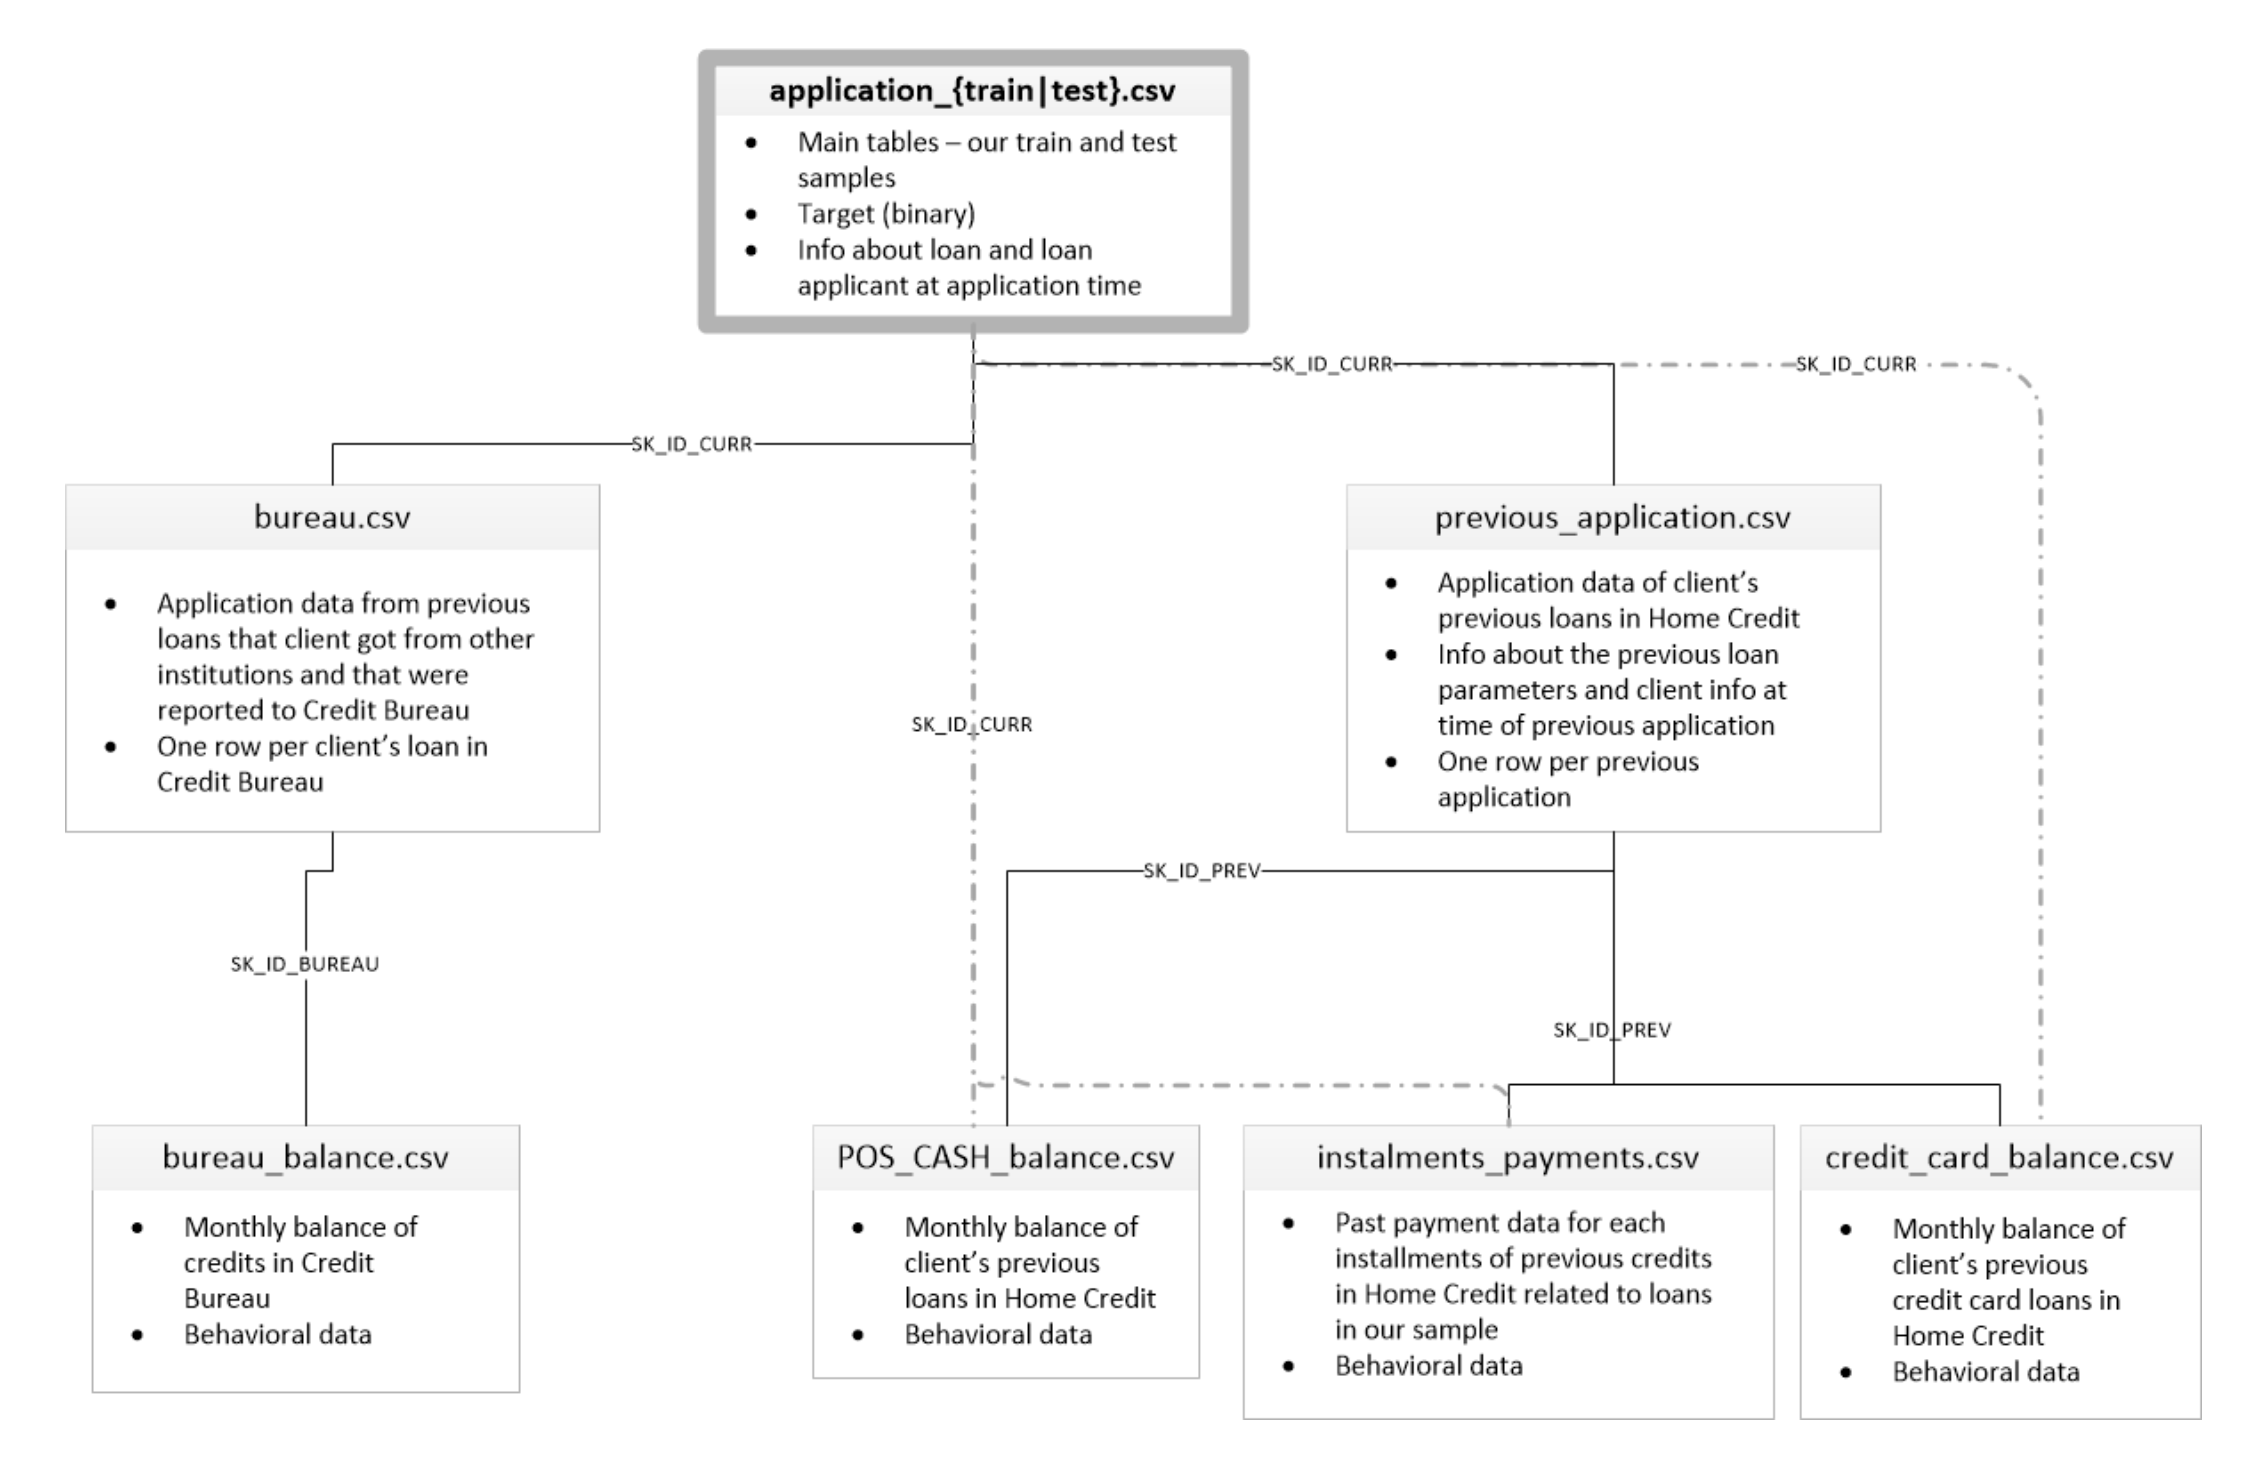

**TARGET** = 1 ou 0 (difficulté à rembourser le pret ou non)  
- Présent uniquement dans "application_train"

# Définition de chaque colonnes

In [11]:
definition_colonnes = pd.read_csv('../../Datasets/HomeCredit_columns_description.csv', encoding='ISO-8859-1')

In [12]:
definition_colonnes.head()

,Unnamed: 0,Table,Row,Description,Special
0,1,application_{train|test}.csv,SK_ID_CURR,ID of loan in our sample,NaN
1,2,application_{train|test}.csv,TARGET,Target variable (1 - client with payment diffi...,NaN
2,5,application_{train|test}.csv,NAME_CONTRACT_TYPE,Identification if loan is cash or revolving,NaN
3,6,application_{train|test}.csv,CODE_GENDER,Gender of the client,NaN
4,7,application_{train|test}.csv,FLAG_OWN_CAR,Flag if the client owns a car,NaN


# application_train/test

**On importe le csv application_train**

In [13]:
df = pd.read_csv('../../Datasets/application_train.csv')

In [14]:
print(df.shape)
df.head()

(307511, 122)


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,...,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637,-3648.0,-2120,NaN,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,0.083037,0.262949,0.139376,0.0247,0.0369,0.9722,0.6192,0.0143,0.00,...,0.0250,0.0369,0.9722,0.6243,0.0144,0.00,0.0690,0.0833,0.1250,0.0375,0.0205,0.0193,0.0000,0.00,reg oper account,block of flats,0.0149,"Stone, brick",No,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,-16765,-1188,-1186.0,-291,NaN,1,1,0,1,1,0,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,0,School,0.311267,0.622246,NaN,0.0959,0.0529,0.9851,0.7960,0.0605,0.08,...,0.0968,0.0529,0.9851,0.7987,0.0608,0.08,0.0345,0.2917,0.3333,0.0132,0.0787,0.0558,0.0039,0.01,reg oper account,block of flats,0.0714,Block,No,1.0,0.0,1.0,0.0,-828.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010032,-19046,-225,-4260.0,-2531,26.0,1,1,1,1,1,0,Laborers,1.0,2,2,MONDAY,9,0,0,0,0,0,0,Government,NaN,0.555912,0.729567,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-815.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,297000.0,Unaccompanied,Working,Secondary / secondary special,Civil marriage,House / apartment,0.008019,-19005,-3039,-9833.0,-2437,NaN,1,1,0,1,0,0,Laborers,2.0,2,2,WEDNESDAY,17,0,0,0,0,0,0,Business Entity Type 3,NaN,0.650442,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,0.0,2.0,0.0,-617.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,513000.0,Unaccompanied,Working,Secondary / secondary special,Single /

**On importe le csv application_test**

In [15]:
test_df = pd.read_csv('../../Datasets/application_test.csv')

In [16]:
print(test_df.shape)
test_df.head()

(48744, 121)


,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,...,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100001,Cash loans,F,N,Y,0,135000.0,568800.0,20560.5,450000.0,Unaccompanied,Working,Higher education,Married,House / apartment,0.018850,-19241,-2329,-5170.0,-812,NaN,1,1,0,1,0,1,NaN,2.0,2,2,TUESDAY,18,0,0,0,0,0,0,Kindergarten,0.752614,0.789654,0.159520,0.0660,0.0590,0.9732,NaN,NaN,NaN,0.1379,...,0.0666,0.0590,0.9732,NaN,NaN,NaN,0.1379,0.125,NaN,NaN,NaN,0.0514,NaN,NaN,NaN,block of flats,0.0392,"Stone, brick",No,0.0,0.0,0.0,0.0,-1740.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
1,100005,Cash loans,M,N,Y,0,99000.0,222768.0,17370.0,180000.0,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,0.035792,-18064,-4469,-9118.0,-1623,NaN,1,1,0,1,0,0,Low-skill Laborers,2.0,2,2,FRIDAY,9,0,0,0,0,0,0,Self-employed,0.564990,0.291656,0.432962,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
2,100013,Cash loans,M,Y,Y,0,202500.0,663264.0,69777.0,630000.0,NaN,Working,Higher education,Married,House / apartment,0.019101,-20038,-4458,-2175.0,-3503,5.0,1,1,0,1,0,0,Drivers,2.0,2,2,MONDAY,14,0,0,0,0,0,0,Transport: type 3,NaN,0.699787,0.610991,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-856.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,1.0,4.0
3,100028,Cash loans,F,N,Y,2,315000.0,1575000.0,49018.5,1575000.0,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,0.026392,-13976,-1866,-2000.0,-4208,NaN,1,1,0,1,1,0,Sales staff,4.0,2,2,WEDNESDAY,11,0,0,0,0,0,0,Business Entity Type 3,0.525734,0.509677,0.612704,0.3052,0.1974,0.9970,0.9592,0.1165,0.32,0.2759,...,0.3081,0.1974,0.9970,0.9597,0.1173,0.32,0.2759,0.375,0.0417,0.2078,0.2446,0.3739,0.0388,0.0817,reg oper account,block of flats,0.3700,Panel,No,0.0,0.0,0.0,0.0,-1805.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
4,100038,Cash loans,M,Y,N,1,180000.0,625500.0,32067.0,625500.0,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,0.010032,-13040,-2191,-4000.0,-4262,16.0

**On va fusionner les csv train + test**

In [17]:
df = pd.concat([df, test_df], ignore_index=True)

In [18]:
print(df.shape)

(356255, 122)


**On va supprimer la colonne "test_df" qui nous sert plus a rien**

In [19]:
del test_df

**On supprime les lignes ou on ne connait pas le sexe de la personne**

In [20]:
df = df[df['CODE_GENDER'] != 'XNA']

In [21]:
print(df.shape)

(356251, 122)


**On pratique le one_hot_encoder sur nos colonnes catégorielles**

In [22]:
df, cat_cols = one_hot_encoder(df, nan_as_category = False)

In [23]:
print(df.shape)

(356251, 245)


**On supprime des valeurs abérantes dans la colonne "DAYS_EMPLOYED"**

In [24]:
definition_colonnes[definition_colonnes["Row"] == "DAYS_EMPLOYED"]

,Unnamed: 0,Table,Row,Description,Special
18,21,application_{train|test}.csv,DAYS_EMPLOYED,How many days before the application the perso...,time only relative to the application


In [25]:
df[df['DAYS_EMPLOYED'] == 365243].shape

(64648, 245)

On a ~64000 lignes ou ce nombre de jours est égal a 1000 ans... 

In [26]:
df['DAYS_EMPLOYED'].replace(365243, np.nan, inplace= True)

**Création de nouvelles features**

**DAYS_EMPLOYED_PERC:**
- Pourcentage de la vie d'une personne qu'elle a passé à travailler.
- Si cette valeur est élevée, cela signifie que la personne a travaillé pendant une grande partie de sa vie.

In [27]:
df['DAYS_EMPLOYED_PERC'] = df['DAYS_EMPLOYED'] / df['DAYS_BIRTH']
print(df.shape)

(356251, 246)


**INCOME_CREDIT_PERC:**
- Rapport entre le revenu total d'une personne et le montant total du crédit qu'elle a reçu.
- Une valeur élevée signifie que le revenu de la personne est élevé par rapport à son crédit, ce qui pourrait indiquer une meilleure capacité à rembourser.

In [28]:
df['INCOME_CREDIT_PERC'] = df['AMT_INCOME_TOTAL'] / df['AMT_CREDIT']
print(df.shape)

(356251, 247)


**INCOME_PER_PERSON:**
- Revenu moyen par membre de la famille.
- Donne une idée du revenu individuel si le revenu total était distribué également entre tous les membres de la famille.

In [29]:
df['INCOME_PER_PERSON'] = df['AMT_INCOME_TOTAL'] / df['CNT_FAM_MEMBERS']
print(df.shape)

(356251, 248)


**ANNUITY_INCOME_PERC:**
- Rapport entre le montant de l'annuité (paiements périodiques) et le revenu total d'une personne.
- Une valeur élevée signifie que les paiements d'annuité prennent une grande part du revenu -> pression financière plus élevée

In [30]:
df['ANNUITY_INCOME_PERC'] = df['AMT_ANNUITY'] / df['AMT_INCOME_TOTAL']
print(df.shape)

(356251, 249)


**PAYMENT_RATE:**
- Proportion du crédit qui est remboursée annuellement. 
- Une valeur élevée signifie que le crédit sera remboursé plus rapidement.

In [31]:
df['PAYMENT_RATE'] = df['AMT_ANNUITY'] / df['AMT_CREDIT']
print(df.shape)

(356251, 250)


# bureau et bureau_balance

In [32]:
bureau = pd.read_csv('../../Datasets/bureau.csv')
bb = pd.read_csv('../../Datasets/bureau_balance.csv')

In [33]:
bureau.head()

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.0,0.0,NaN,0.0,Consumer credit,-131,NaN
1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.0,171342.0,NaN,0.0,Credit card,-20,NaN
2,215354,5714464,Active,currency 1,-203,0,528.0,NaN,NaN,0,464323.5,NaN,NaN,0.0,Consumer credit,-16,NaN
3,215354,5714465,Active,currency 1,-203,0,NaN,NaN,NaN,0,90000.0,NaN,NaN,0.0,Credit card,-16,NaN
4,215354,5714466,Active,currency 1,-629,0,1197.0,NaN,77674.5,0,2700000.0,NaN,NaN,0.0,Consumer credit,-21,NaN


In [34]:
bb.head()

,SK_ID_BUREAU,MONTHS_BALANCE,STATUS
0,5715448,0,C
1,5715448,-1,C
2,5715448,-2,C
3,5715448,-3,C
4,5715448,-4,C


In [35]:
print(bureau.shape)
print(bb.shape)

(1716428, 17)
(27299925, 3)


**On procède au one_hot_encoding sur ces 2 dataframes**

In [36]:
bb, bb_cat = one_hot_encoder(bb, nan_as_category = True)
bureau, bureau_cat = one_hot_encoder(bureau, nan_as_category = True)

In [37]:
print(bureau.shape)
print(bb.shape)

(1716428, 40)
(27299925, 11)


In [38]:
bb.head()

,SK_ID_BUREAU,MONTHS_BALANCE,STATUS_0,STATUS_1,STATUS_2,STATUS_3,STATUS_4,STATUS_5,STATUS_C,STATUS_X,STATUS_nan
0,5715448,0,False,False,False,False,False,False,True,False,False
1,5715448,-1,False,False,False,False,False,False,True,False,False
2,5715448,-2,False,False,False,False,False,False,True,False,False
3,5715448,-3,False,False,False,False,False,False,True,False,False
4,5715448,-4,False,False,False,False,False,False,True,False,False


**On effectue la stratégie suivante sur les colonnes de bureau_balance**

In [39]:
bb_aggregations = {'MONTHS_BALANCE': ['min', 'max', 'size']}
for col in bb_cat:
    bb_aggregations[col] = ['mean']

In [40]:
bb_aggregations

{'MONTHS_BALANCE': ['min', 'max', 'size'],
 'STATUS_0': ['mean'],
 'STATUS_1': ['mean'],
 'STATUS_2': ['mean'],
 'STATUS_3': ['mean'],
 'STATUS_4': ['mean'],
 'STATUS_5': ['mean'],
 'STATUS_C': ['mean'],
 'STATUS_X': ['mean'],
 'STATUS_nan': ['mean']}

**On applique l'aggregation de bb en créant bb_agg**

In [41]:
bb_agg = bb.groupby('SK_ID_BUREAU').agg(bb_aggregations)
bb_agg.columns = pd.Index([e[0] + "_" + e[1].upper() for e in bb_agg.columns.tolist()])

In [42]:
bb_agg.head()

,MONTHS_BALANCE_MIN,MONTHS_BALANCE_MAX,MONTHS_BALANCE_SIZE,STATUS_0_MEAN,STATUS_1_MEAN,STATUS_2_MEAN,STATUS_3_MEAN,STATUS_4_MEAN,STATUS_5_MEAN,STATUS_C_MEAN,STATUS_X_MEAN,STATUS_nan_MEAN
SK_ID_BUREAU,,,,,,,,,,,,
5001709,-96,0,97,0.000000,0.0,0.0,0.0,0.0,0.0,0.886598,0.113402,0.0
5001710,-82,0,83,0.060241,0.0,0.0,0.0,0.0,0.0,0.578313,0.361446,0.0
5001711,-3,0,4,0.750000,0.0,0.0,0.0,0.0,0.0,0.000000,0.250000,0.0
5001712,-18,0,19,0.526316,0.0,0.0,0.0,0.0,0.0,0.473684,0.000000,0.0
5001713,-21,0,22,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,1.000000,0.0


**On fusionne bureau et bureau_balance_agrégée**

In [43]:
bureau = bureau.join(bb_agg, how='left', on='SK_ID_BUREAU')
bureau.drop(['SK_ID_BUREAU'], axis=1, inplace= True)
bureau.shape

(1716428, 51)

**On supprime bb et bb_agg**

In [44]:
del bb, bb_agg

**Stratégies pour les variables NON catégorielles de bureau:**

In [45]:
# Bureau et bureau_balance numeric features
num_aggregations = {
    'DAYS_CREDIT': ['min', 'max', 'mean', 'var'],
    'DAYS_CREDIT_ENDDATE': ['min', 'max', 'mean'],
    'DAYS_CREDIT_UPDATE': ['mean'],
    'CREDIT_DAY_OVERDUE': ['max', 'mean'],
    'AMT_CREDIT_MAX_OVERDUE': ['mean'],
    'AMT_CREDIT_SUM': ['max', 'mean', 'sum'],
    'AMT_CREDIT_SUM_DEBT': ['max', 'mean', 'sum'],
    'AMT_CREDIT_SUM_OVERDUE': ['mean'],
    'AMT_CREDIT_SUM_LIMIT': ['mean', 'sum'],
    'AMT_ANNUITY': ['max', 'mean'],
    'CNT_CREDIT_PROLONG': ['sum'],
    'MONTHS_BALANCE_MIN': ['min'],
    'MONTHS_BALANCE_MAX': ['max'],
    'MONTHS_BALANCE_SIZE': ['mean', 'sum']
}

**Stratégies pour les variables catégorielles de bureau (moyenne):**

In [46]:
# Bureau and bureau_balance categorical features
cat_aggregations = {}
for cat in bureau_cat: cat_aggregations[cat] = ['mean']
for cat in bb_cat: cat_aggregations[cat + "_MEAN"] = ['mean']

**Aggregation des lignes de bureau (création de bureau_agg)**

In [47]:
bureau_agg = bureau.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
bureau_agg.columns = pd.Index(['BURO_' + e[0] + "_" + e[1].upper() for e in bureau_agg.columns.tolist()])

In [48]:
print(bureau_agg.shape)
bureau_agg.head()

(305811, 62)


,BURO_DAYS_CREDIT_MIN,BURO_DAYS_CREDIT_MAX,BURO_DAYS_CREDIT_MEAN,BURO_DAYS_CREDIT_VAR,BURO_DAYS_CREDIT_ENDDATE_MIN,BURO_DAYS_CREDIT_ENDDATE_MAX,BURO_DAYS_CREDIT_ENDDATE_MEAN,BURO_DAYS_CREDIT_UPDATE_MEAN,BURO_CREDIT_DAY_OVERDUE_MAX,BURO_CREDIT_DAY_OVERDUE_MEAN,BURO_AMT_CREDIT_MAX_OVERDUE_MEAN,BURO_AMT_CREDIT_SUM_MAX,BURO_AMT_CREDIT_SUM_MEAN,BURO_AMT_CREDIT_SUM_SUM,BURO_AMT_CREDIT_SUM_DEBT_MAX,BURO_AMT_CREDIT_SUM_DEBT_MEAN,BURO_AMT_CREDIT_SUM_DEBT_SUM,BURO_AMT_CREDIT_SUM_OVERDUE_MEAN,BURO_AMT_CREDIT_SUM_LIMIT_MEAN,BURO_AMT_CREDIT_SUM_LIMIT_SUM,BURO_AMT_ANNUITY_MAX,BURO_AMT_ANNUITY_MEAN,BURO_CNT_CREDIT_PROLONG_SUM,BURO_MONTHS_BALANCE_MIN_MIN,BURO_MONTHS_BALANCE_MAX_MAX,BURO_MONTHS_BALANCE_SIZE_MEAN,BURO_MONTHS_BALANCE_SIZE_SUM,BURO_CREDIT_ACTIVE_Active_MEAN,BURO_CREDIT_ACTIVE_Bad debt_MEAN,BURO_CREDIT_ACTIVE_Closed_MEAN,BURO_CREDIT_ACTIVE_Sold_MEAN,BURO_CREDIT_ACTIVE_nan_MEAN,BURO_CREDIT_CURRENCY_currency 1_MEAN,BURO_CREDIT_CURRENCY_currency 2_MEAN,BURO_CREDIT_CURRENCY_currency 3_MEAN,BURO_CREDIT_CURRENCY_currency 4_MEAN,BURO_CREDIT_CURRENCY_nan_MEAN,BURO_CREDIT_TYPE_Another type of loan_MEAN,BURO_CREDIT_TYPE_Car loan_MEAN,BURO_CREDIT_TYPE_Cash loan (non-earmarked)_MEAN,BURO_CREDIT_TYPE_Consumer credit_MEAN,BURO_CREDIT_TYPE_Credit card_MEAN,BURO_CREDIT_TYPE_Interbank credit_MEAN,BURO_CREDIT_TYPE_Loan for business development_MEAN,BURO_CREDIT_TYPE_Loan for purchase of shares (margin lending)_MEAN,BURO_CREDIT_TYPE_Loan for the purchase of equipment_MEAN,BURO_CREDIT_TYPE_Loan for working capital replenishment_MEAN,BURO_CREDIT_TYPE_Microloan_MEAN,BURO_CREDIT_TYPE_Mobile operator loan_MEAN,BURO_CREDIT_TYPE_Mortgage_MEAN,BURO_CREDIT_TYPE_Real estate loan_MEAN,BURO_CREDIT_TYPE_Unknown type of loan_MEAN,BURO_CREDIT_TYPE_nan_MEAN,BURO_STATUS_0_MEAN_MEAN,BURO_STATUS_1_MEAN_MEAN,BURO_STATUS_2_MEAN_MEAN,BURO_STATUS_3_MEAN_MEAN,BURO_STATUS_4_MEAN_MEAN,BURO_STATUS_5_MEAN_MEAN,BURO_STATUS_C_MEAN_MEAN,BURO_STATUS_X_MEAN_MEAN,BURO_STATUS_nan_MEAN_MEAN
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
100001,-1572,-49,-735.000000,240043.666667,-1329.0,1778.0,82.428571,-93.142857,0,0.0,NaN,378000.0,207623.571429,1453365.000,373239.0,85240.928571,596686.5,0.0,0.00000,0.000,10822.5,3545.357143,0,-51.0,0.0,24.571429,172.0,0.428571,0.0,0.571429,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.336651,0.007519,0.0,0.0,0.0,0.0,0.441240,0.214590,0.0
100002,-1437,-103,-874.000000,186150.000000,-1072.0,780.0,-349.000000,-499.875000,0,0.0,1681.029,450000.0,108131.945625,865055.565,245781.0,49156.200000,245781.0,0.0,7997.14125,31988.565,0.0,0.000000,0,-47.0,0.0,13.750000,110.0,0.250000,0.0,0.750000,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.500000,0.500000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.406960,0.255682,0.0,0.0,0.0,0.0,0.175426,0.161932,0.0
100003,-2586,-606,-1400.750000,827783.583333,-2434.0,1216.0,-544.500000,-816.000000,0,0.0,0.000,810000.0,254350.125000,1017400.500,0.0,0.000000,0.0,0.0,202500.00000,810000.000,NaN,NaN,0,NaN,NaN,NaN,0.0,0.250000,0.0,0.750000,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.500000,0.500000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100004,-1326,-408,-867.000000,421362.000000,-595.0,-382.0,-488.500000,-532.000000,0,0.0,0.000,94537.8,94518.900000,189037.800,0.0,0.000000,0.0,0.0,0.00000,0.000,NaN,NaN,0,NaN,NaN,NaN,0.0,0.000000,0.0,1.000000,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100005,-373,-62,-190.666667,26340.333333,-128.0,1324.0,439.333333,-54.333333,0,0.0,0.000,568800.0,219042.000000,657126.000,543087.0,189469.500000,568408.5,0.0,0.00000,0.000,4261.5,1420.500000,0,-12.0,0.0,7.000000,21.0,0.666667,0.0,0.333333,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.666667,0.333333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.735043,0.000000,0.0,0.0,0.0,0.0,0.128205,0.136752,0.0


**On va ajouter dans bureau_agg les crédits actifs uniquement**

In [49]:
active = bureau[bureau['CREDIT_ACTIVE_Active'] == 1]
active_agg = active.groupby('SK_ID_CURR').agg(num_aggregations)
active_agg.columns = pd.Index(['ACTIVE_' + e[0] + "_" + e[1].upper() for e in active_agg.columns.tolist()])
bureau_agg = bureau_agg.join(active_agg, how='left', on='SK_ID_CURR')

In [50]:
bureau_agg.shape

(305811, 89)

**On fait pareil pour les crédits fermés**

In [51]:
closed = bureau[bureau['CREDIT_ACTIVE_Closed'] == 1]
closed_agg = closed.groupby('SK_ID_CURR').agg(num_aggregations)
closed_agg.columns = pd.Index(['CLOSED_' + e[0] + "_" + e[1].upper() for e in closed_agg.columns.tolist()])
bureau_agg = bureau_agg.join(closed_agg, how='left', on='SK_ID_CURR')

In [52]:
bureau_agg.shape

(305811, 116)

# Fusion df avec bureau_agg

In [53]:
df = df.join(bureau_agg, how='left', on='SK_ID_CURR')

In [54]:
print(df.shape)
df.head()

(356251, 366)


,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,...,ACTIVE_DAYS_CREDIT_ENDDATE_MIN,ACTIVE_DAYS_CREDIT_ENDDATE_MAX,ACTIVE_DAYS_CREDIT_ENDDATE_MEAN,ACTIVE_DAYS_CREDIT_UPDATE_MEAN,ACTIVE_CREDIT_DAY_OVERDUE_MAX,ACTIVE_CREDIT_DAY_OVERDUE_MEAN,ACTIVE_AMT_CREDIT_MAX_OVERDUE_MEAN,ACTIVE_AMT_CREDIT_SUM_MAX,ACTIVE_AMT_CREDIT_SUM_MEAN,ACTIVE_AMT_CREDIT_SUM_SUM,ACTIVE_AMT_CREDIT_SUM_DEBT_MAX,ACTIVE_AMT_CREDIT_SUM_DEBT_MEAN,ACTIVE_AMT_CREDIT_SUM_DEBT_SUM,ACTIVE_AMT_CREDIT_SUM_OVERDUE_MEAN,ACTIVE_AMT_CREDIT_SUM_LIMIT_MEAN,ACTIVE_AMT_CREDIT_SUM_LIMIT_SUM,ACTIVE_AMT_ANNUITY_MAX,ACTIVE_AMT_ANNUITY_MEAN,ACTIVE_CNT_CREDIT_PROLONG_SUM,ACTIVE_MONTHS_BALANCE_MIN_MIN,ACTIVE_MONTHS_BALANCE_MAX_MAX,ACTIVE_MONTHS_BALANCE_SIZE_MEAN,ACTIVE_MONTHS_BALANCE_SIZE_SUM,CLOSED_DAYS_CREDIT_MIN,CLOSED_DAYS_CREDIT_MAX,CLOSED_DAYS_CREDIT_MEAN,CLOSED_DAYS_CREDIT_VAR,CLOSED_DAYS_CREDIT_ENDDATE_MIN,CLOSED_DAYS_CREDIT_ENDDATE_MAX,CLOSED_DAYS_CREDIT_ENDDATE_MEAN,CLOSED_DAYS_CREDIT_UPDATE_MEAN,CLOSED_CREDIT_DAY_OVERDUE_MAX,CLOSED_CREDIT_DAY_OVERDUE_MEAN,CLOSED_AMT_CREDIT_MAX_OVERDUE_MEAN,CLOSED_AMT_CREDIT_SUM_MAX,CLOSED_AMT_CREDIT_SUM_MEAN,CLOSED_AMT_CREDIT_SUM_SUM,CLOSED_AMT_CREDIT_SUM_DEBT_MAX,CLOSED_AMT_CREDIT_SUM_DEBT_MEAN,CLOSED_AMT_CREDIT_SUM_DEBT_SUM,CLOSED_AMT_CREDIT_SUM_OVERDUE_MEAN,CLOSED_AMT_CREDIT_SUM_LIMIT_MEAN,CLOSED_AMT_CREDIT_SUM_LIMIT_SUM,CLOSED_AMT_ANNUITY_MAX,CLOSED_AMT_ANNUITY_MEAN,CLOSED_CNT_CREDIT_PROLONG_SUM,CLOSED_MONTHS_BALANCE_MIN_MIN,CLOSED_MONTHS_BALANCE_MAX_MAX,CLOSED_MONTHS_BALANCE_SIZE_MEAN,CLOSED_MONTHS_BALANCE_SIZE_SUM
0,100002,1.0,0,202500.0,406597.5,24700.5,351000.0,0.018801,-9461,-637.0,-3648.0,-2120,NaN,1,1,0,1,1,0,1.0,2,2,10,0,0,0,0,0,0,0.083037,0.262949,0.139376,0.0247,0.0369,0.9722,0.6192,0.0143,0.00,0.0690,0.0833,0.1250,0.0369,0.0202,0.0190,0.0000,0.0000,0.0252,0.0383,0.9722,0.6341,...,780.0,780.0,780.0,-15.5,0.0,0.0,40.5,450000.0,240994.2825,481988.565,245781.0,122890.5,245781.0,0.0,15994.2825,31988.565,0.0,0.0,0.0,-34.0,0.0,10.0,20.0,-1437.0,-476.0,-974.500000,123956.700000,-1072.0,85.0,-574.800000,-661.333333,0.0,0.0,2091.16125,135000.0,63844.5,383067.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-47.0,0.0,15.0,90.0
1,100003,0.0,0,270000.0,1293502.5,35698.5,1129500.0,0.003541,-16765,-1188.0,-1186.0,-291,NaN,1,1,0,1,1,0,2.0,1,1,11,0,0,0,0,0,0,0.311267,0.622246,NaN,0.0959,0.0529,0.9851,0.7960,0.0605,0.08,0.0345,0.2917,0.3333,0.0130,0.0773,0.0549,0.0039,0.0098,0.0924,0.0538,0.9851,0.8040,...,1216.0,1216.0,1216.0,-43.0,0.0,0.0,0.0,810000.0,810000.0000,810000.000,0.0,0.0,0.0,0.0,810000.0000,810000.000,NaN,NaN,0.0,NaN,NaN,NaN,0.0,-2586.0,-775.0,-1665.666667,820590.333333,-2434.0,-420.0,-1131.333333,-1073.666667,0.0,0.0,0.00000,112500.0,69133.5,207400.5,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,0.0
2,100004,0.0,0,67500.0,135000.0,6750.0,135000.0,0.010032,-19046,-225.0,-4260.0,-2531,26.0,1,1,1,1,1,0,1.0,2,2,9,0,0,0,0,0,0,NaN,0.555912,0.729567,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1326.0,-408.0,-867.000000,421362.000000,-595.0,-382.0,-488.500000,-532.000000,0.0,0.0,0.00000,94537.8,94518.9,189037.8,0.0,0.0,0.0

# previous_applications

In [55]:
prev = pd.read_csv('../../Datasets/previous_application.csv')

In [56]:
print(prev.shape)
prev.head()

(1670214, 37)


,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,FLAG_LAST_APPL_PER_CONTRACT,NFLAG_LAST_APPL_IN_DAY,RATE_DOWN_PAYMENT,RATE_INTEREST_PRIMARY,RATE_INTEREST_PRIVILEGED,NAME_CASH_LOAN_PURPOSE,NAME_CONTRACT_STATUS,DAYS_DECISION,NAME_PAYMENT_TYPE,CODE_REJECT_REASON,NAME_TYPE_SUITE,NAME_CLIENT_TYPE,NAME_GOODS_CATEGORY,NAME_PORTFOLIO,NAME_PRODUCT_TYPE,CHANNEL_TYPE,SELLERPLACE_AREA,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
0,2030495,271877,Consumer loans,1730.430,17145.0,17145.0,0.0,17145.0,SATURDAY,15,Y,1,0.0,0.182832,0.867336,XAP,Approved,-73,Cash through the bank,XAP,NaN,Repeater,Mobile,POS,XNA,Country-wide,35,Connectivity,12.0,middle,POS mobile with interest,365243.0,-42.0,300.0,-42.0,-37.0,0.0
1,2802425,108129,Cash loans,25188.615,607500.0,679671.0,NaN,607500.0,THURSDAY,11,Y,1,NaN,NaN,NaN,XNA,Approved,-164,XNA,XAP,Unaccompanied,Repeater,XNA,Cash,x-sell,Contact center,-1,XNA,36.0,low_action,Cash X-Sell: low,365243.0,-134.0,916.0,365243.0,365243.0,1.0
2,2523466,122040,Cash loans,15060.735,112500.0,136444.5,NaN,112500.0,TUESDAY,11,Y,1,NaN,NaN,NaN,XNA,Approved,-301,Cash through the bank,XAP,"Spouse, partner",Repeater,XNA,Cash,x-sell,Credit and cash offices,-1,XNA,12.0,high,Cash X-Sell: high,365243.0,-271.0,59.0,365243.0,365243.0,1.0
3,2819243,176158,Cash loans,47041.335,450000.0,470790.0,NaN,450000.0,MONDAY,7,Y,1,NaN,NaN,NaN,XNA,Approved,-512,Cash through the bank,XAP,NaN,Repeater,XNA,Cash,x-sell,Credit and cash offices,-1,XNA,12.0,middle,Cash X-Sell: middle,365243.0,-482.0,-152.0,-182.0,-177.0,1.0
4,1784265,202054,Cash loans,31924.395,337500.0,404055.0,NaN,337500.0,THURSDAY,9,Y,1,NaN,NaN,NaN,Repairs,Refused,-781,Cash through the bank,HC,NaN,Repeater,XNA,Cash,walk-in,Credit and cash offices,-1,XNA,24.0,high,Cash Street: high,NaN,NaN,NaN,NaN,NaN,NaN


**On effectue le one_hot_encoder**

In [57]:
prev, cat_cols = one_hot_encoder(prev, nan_as_category= True)

In [58]:
print(prev.shape)

(1670214, 180)


**Comme précédemment on supprime les valeurs abrérantes (ou le nb de jours = 365243 = 1000 ans)**

In [59]:
prev['DAYS_FIRST_DRAWING'].replace(365243, np.nan, inplace= True)
prev['DAYS_FIRST_DUE'].replace(365243, np.nan, inplace= True)
prev['DAYS_LAST_DUE_1ST_VERSION'].replace(365243, np.nan, inplace= True)
prev['DAYS_LAST_DUE'].replace(365243, np.nan, inplace= True)
prev['DAYS_TERMINATION'].replace(365243, np.nan, inplace= True)

**Création d'une feature "APP_CREDIT_PERC":**


In [60]:
definition_colonnes[definition_colonnes["Row"] == "AMT_APPLICATION"]

,Unnamed: 0,Table,Row,Description,Special
177,180,previous_application.csv,AMT_APPLICATION,For how much credit did client ask on the prev...,NaN


- Montant que le client souhaitait emprunter lorsqu'il a soumis sa demande

In [61]:
definition_colonnes[definition_colonnes["Row"] == "AMT_CREDIT"]

,Unnamed: 0,Table,Row,Description,Special
8,11,application_{train|test}.csv,AMT_CREDIT,Credit amount of the loan,NaN
178,181,previous_application.csv,AMT_CREDIT,Final credit amount on the previous applicatio...,NaN


- Montant du crédit qui a finalement été accordé au client lors de sa demande précédente

APP_CREDIT_PERC: Donne une idée de la manière dont le montant demandé par le client se compare au montant réellement accordé 

In [62]:
prev['APP_CREDIT_PERC'] = prev['AMT_APPLICATION'] / prev['AMT_CREDIT']

**Voici la stratégie d'aggrégation pour les colonnes NON catégorielles:**

In [63]:
num_aggregations = {
    'AMT_ANNUITY': ['min', 'max', 'mean'],
    'AMT_APPLICATION': ['min', 'max', 'mean'],
    'AMT_CREDIT': ['min', 'max', 'mean'],
    'APP_CREDIT_PERC': ['min', 'max', 'mean', 'var'],
    'AMT_DOWN_PAYMENT': ['min', 'max', 'mean'],
    'AMT_GOODS_PRICE': ['min', 'max', 'mean'],
    'HOUR_APPR_PROCESS_START': ['min', 'max', 'mean'],
    'RATE_DOWN_PAYMENT': ['min', 'max', 'mean'],
    'DAYS_DECISION': ['min', 'max', 'mean'],
    'CNT_PAYMENT': ['mean', 'sum'],
}

**Voici la stratégie d'aggrégation pour les colonnes catégorielles (moyenne):**

In [64]:
cat_aggregations = {}
for cat in cat_cols:
    cat_aggregations[cat] = ['mean']

**On effectue l'aggrégation sur prev (donnant prev_agg)**

In [65]:
prev_agg = prev.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
prev_agg.columns = pd.Index(['PREV_' + e[0] + "_" + e[1].upper() for e in prev_agg.columns.tolist()])

In [66]:
print(prev_agg.shape)
prev_agg.head()

(338857, 189)


,PREV_AMT_ANNUITY_MIN,PREV_AMT_ANNUITY_MAX,PREV_AMT_ANNUITY_MEAN,PREV_AMT_APPLICATION_MIN,PREV_AMT_APPLICATION_MAX,PREV_AMT_APPLICATION_MEAN,PREV_AMT_CREDIT_MIN,PREV_AMT_CREDIT_MAX,PREV_AMT_CREDIT_MEAN,PREV_APP_CREDIT_PERC_MIN,PREV_APP_CREDIT_PERC_MAX,PREV_APP_CREDIT_PERC_MEAN,PREV_APP_CREDIT_PERC_VAR,PREV_AMT_DOWN_PAYMENT_MIN,PREV_AMT_DOWN_PAYMENT_MAX,PREV_AMT_DOWN_PAYMENT_MEAN,PREV_AMT_GOODS_PRICE_MIN,PREV_AMT_GOODS_PRICE_MAX,PREV_AMT_GOODS_PRICE_MEAN,PREV_HOUR_APPR_PROCESS_START_MIN,PREV_HOUR_APPR_PROCESS_START_MAX,PREV_HOUR_APPR_PROCESS_START_MEAN,PREV_RATE_DOWN_PAYMENT_MIN,PREV_RATE_DOWN_PAYMENT_MAX,PREV_RATE_DOWN_PAYMENT_MEAN,PREV_DAYS_DECISION_MIN,PREV_DAYS_DECISION_MAX,PREV_DAYS_DECISION_MEAN,PREV_CNT_PAYMENT_MEAN,PREV_CNT_PAYMENT_SUM,PREV_NAME_CONTRACT_TYPE_Cash loans_MEAN,PREV_NAME_CONTRACT_TYPE_Consumer loans_MEAN,PREV_NAME_CONTRACT_TYPE_Revolving loans_MEAN,PREV_NAME_CONTRACT_TYPE_XNA_MEAN,PREV_NAME_CONTRACT_TYPE_nan_MEAN,PREV_WEEKDAY_APPR_PROCESS_START_FRIDAY_MEAN,PREV_WEEKDAY_APPR_PROCESS_START_MONDAY_MEAN,PREV_WEEKDAY_APPR_PROCESS_START_SATURDAY_MEAN,PREV_WEEKDAY_APPR_PROCESS_START_SUNDAY_MEAN,PREV_WEEKDAY_APPR_PROCESS_START_THURSDAY_MEAN,PREV_WEEKDAY_APPR_PROCESS_START_TUESDAY_MEAN,PREV_WEEKDAY_APPR_PROCESS_START_WEDNESDAY_MEAN,PREV_WEEKDAY_APPR_PROCESS_START_nan_MEAN,PREV_FLAG_LAST_APPL_PER_CONTRACT_N_MEAN,PREV_FLAG_LAST_APPL_PER_CONTRACT_Y_MEAN,PREV_FLAG_LAST_APPL_PER_CONTRACT_nan_MEAN,PREV_NAME_CASH_LOAN_PURPOSE_Building a house or an annex_MEAN,PREV_NAME_CASH_LOAN_PURPOSE_Business development_MEAN,PREV_NAME_CASH_LOAN_PURPOSE_Buying a garage_MEAN,PREV_NAME_CASH_LOAN_PURPOSE_Buying a holiday home / land_MEAN,...,PREV_NAME_PORTFOLIO_nan_MEAN,PREV_NAME_PRODUCT_TYPE_XNA_MEAN,PREV_NAME_PRODUCT_TYPE_walk-in_MEAN,PREV_NAME_PRODUCT_TYPE_x-sell_MEAN,PREV_NAME_PRODUCT_TYPE_nan_MEAN,PREV_CHANNEL_TYPE_AP+ (Cash loan)_MEAN,PREV_CHANNEL_TYPE_Car dealer_MEAN,PREV_CHANNEL_TYPE_Channel of corporate sales_MEAN,PREV_CHANNEL_TYPE_Contact center_MEAN,PREV_CHANNEL_TYPE_Country-wide_MEAN,PREV_CHANNEL_TYPE_Credit and cash offices_MEAN,PREV_CHANNEL_TYPE_Regional / Local_MEAN,PREV_CHANNEL_TYPE_Stone_MEAN,PREV_CHANNEL_TYPE_nan_MEAN,PREV_NAME_SELLER_INDUSTRY_Auto technology_MEAN,PREV_NAME_SELLER_INDUSTRY_Clothing_MEAN,PREV_NAME_SELLER_INDUSTRY_Connectivity_MEAN,PREV_NAME_SELLER_INDUSTRY_Construction_MEAN,PREV_NAME_SELLER_INDUSTRY_Consumer electronics_MEAN,PREV_NAME_SELLER_INDUSTRY_Furniture_MEAN,PREV_NAME_SELLER_INDUSTRY_Industry_MEAN,PREV_NAME_SELLER_INDUSTRY_Jewelry_MEAN,PREV_NAME_SELLER_INDUSTRY_MLM partners_MEAN,PREV_NAME_SELLER_INDUSTRY_Tourism_MEAN,PREV_NAME_SELLER_INDUSTRY_XNA_MEAN,PREV_NAME_SELLER_INDUSTRY_nan_MEAN,PREV_NAME_YIELD_GROUP_XNA_MEAN,PREV_NAME_YIELD_GROUP_high_MEAN,PREV_NAME_YIELD_GROUP_low_action_MEAN,PREV_NAME_YIELD_GROUP_low_normal_MEAN,PREV_NAME_YIELD_GROUP_middle_MEAN,PREV_NAME_YIELD_GROUP_nan_MEAN,PREV_PRODUCT_COMBINATION_Card Street_MEAN,PREV_PRODUCT_COMBINATION_Card X-Sell_MEAN,PREV_PRODUCT_COMBINATION_Cash_MEAN,PREV_PRODUCT_COMBINATION_Cash Street: high_MEAN,PREV_PRODUCT_COMBINATION_Cash Street: low_MEAN,PREV_PRODUCT_COMBINATION_Cash Street: middle_MEAN,PREV_PRODUCT_COMBINATION_Cash X-Sell: high_MEAN,PREV_PRODUCT_COMBINATION_Cash X-Sell: low_MEAN,PREV_PRODUCT_COMBINATION_Cash X-Sell: middle_MEAN,PREV_PRODUCT_COMBINATION_POS household with interest_MEAN,PREV_PRODUCT_COMBINATION_POS household without interest_MEAN,PREV_PRODUCT_COMBINATION_POS industry with interest_MEAN,PREV_PRODUCT_COMBINATION_POS industry without interest_MEAN,PREV_PRODUCT_COMBINATION_POS mobile with interest_MEAN,PREV_PRODUCT_COMBINATION_POS mobile without interest_MEAN,PREV_PRODUCT_COMBINATION_POS other with interest_MEAN,PREV_PRODUCT_COMBINATION_POS others without interest_MEAN,PREV_PRODUCT_COMBINATION_nan_MEAN
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
100001,3951.000,3951.000,3951.000,24835.5,24835.5,24835.50,23787.0,23787.0,23787.00,1.044079,1.044079,1.044079,NaN,252

**On rajoute les colonnes "STATUS_Approved" et "Status_Refused" dans prev_agg**

In [67]:
approved = prev[prev['NAME_CONTRACT_STATUS_Approved'] == 1]
approved_agg = approved.groupby('SK_ID_CURR').agg(num_aggregations)
approved_agg.columns = pd.Index(['APPROVED_' + e[0] + "_" + e[1].upper() for e in approved_agg.columns.tolist()])
prev_agg = prev_agg.join(approved_agg, how='left', on='SK_ID_CURR')

refused = prev[prev['NAME_CONTRACT_STATUS_Refused'] == 1]
refused_agg = refused.groupby('SK_ID_CURR').agg(num_aggregations)
refused_agg.columns = pd.Index(['REFUSED_' + e[0] + "_" + e[1].upper() for e in refused_agg.columns.tolist()])
prev_agg = prev_agg.join(refused_agg, how='left', on='SK_ID_CURR')

In [68]:
prev_agg.shape

(338857, 249)

# Fusion df et prev_agg

In [69]:
df = df.join(prev_agg, how='left', on='SK_ID_CURR')

In [70]:
print(df.shape)
df.head()

(356251, 615)


,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,...,APPROVED_APP_CREDIT_PERC_MAX,APPROVED_APP_CREDIT_PERC_MEAN,APPROVED_APP_CREDIT_PERC_VAR,APPROVED_AMT_DOWN_PAYMENT_MIN,APPROVED_AMT_DOWN_PAYMENT_MAX,APPROVED_AMT_DOWN_PAYMENT_MEAN,APPROVED_AMT_GOODS_PRICE_MIN,APPROVED_AMT_GOODS_PRICE_MAX,APPROVED_AMT_GOODS_PRICE_MEAN,APPROVED_HOUR_APPR_PROCESS_START_MIN,APPROVED_HOUR_APPR_PROCESS_START_MAX,APPROVED_HOUR_APPR_PROCESS_START_MEAN,APPROVED_RATE_DOWN_PAYMENT_MIN,APPROVED_RATE_DOWN_PAYMENT_MAX,APPROVED_RATE_DOWN_PAYMENT_MEAN,APPROVED_DAYS_DECISION_MIN,APPROVED_DAYS_DECISION_MAX,APPROVED_DAYS_DECISION_MEAN,APPROVED_CNT_PAYMENT_MEAN,APPROVED_CNT_PAYMENT_SUM,REFUSED_AMT_ANNUITY_MIN,REFUSED_AMT_ANNUITY_MAX,REFUSED_AMT_ANNUITY_MEAN,REFUSED_AMT_APPLICATION_MIN,REFUSED_AMT_APPLICATION_MAX,REFUSED_AMT_APPLICATION_MEAN,REFUSED_AMT_CREDIT_MIN,REFUSED_AMT_CREDIT_MAX,REFUSED_AMT_CREDIT_MEAN,REFUSED_APP_CREDIT_PERC_MIN,REFUSED_APP_CREDIT_PERC_MAX,REFUSED_APP_CREDIT_PERC_MEAN,REFUSED_APP_CREDIT_PERC_VAR,REFUSED_AMT_DOWN_PAYMENT_MIN,REFUSED_AMT_DOWN_PAYMENT_MAX,REFUSED_AMT_DOWN_PAYMENT_MEAN,REFUSED_AMT_GOODS_PRICE_MIN,REFUSED_AMT_GOODS_PRICE_MAX,REFUSED_AMT_GOODS_PRICE_MEAN,REFUSED_HOUR_APPR_PROCESS_START_MIN,REFUSED_HOUR_APPR_PROCESS_START_MAX,REFUSED_HOUR_APPR_PROCESS_START_MEAN,REFUSED_RATE_DOWN_PAYMENT_MIN,REFUSED_RATE_DOWN_PAYMENT_MAX,REFUSED_RATE_DOWN_PAYMENT_MEAN,REFUSED_DAYS_DECISION_MIN,REFUSED_DAYS_DECISION_MAX,REFUSED_DAYS_DECISION_MEAN,REFUSED_CNT_PAYMENT_MEAN,REFUSED_CNT_PAYMENT_SUM
0,100002,1.0,0,202500.0,406597.5,24700.5,351000.0,0.018801,-9461,-637.0,-3648.0,-2120,NaN,1,1,0,1,1,0,1.0,2,2,10,0,0,0,0,0,0,0.083037,0.262949,0.139376,0.0247,0.0369,0.9722,0.6192,0.0143,0.00,0.0690,0.0833,0.1250,0.0369,0.0202,0.0190,0.0000,0.0000,0.0252,0.0383,0.9722,0.6341,...,1.000000,1.000000,NaN,0.00,0.0,0.00,179055.00,179055.0,179055.000,9.0,9.0,9.000000,0.000000,0.000000,0.000000,-606.0,-606.0,-606.000000,24.000000,24.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,100003,0.0,0,270000.0,1293502.5,35698.5,1129500.0,0.003541,-16765,-1188.0,-1186.0,-291,NaN,1,1,0,1,1,0,2.0,1,1,11,0,0,0,0,0,0,0.311267,0.622246,NaN,0.0959,0.0529,0.9851,0.7960,0.0605,0.08,0.0345,0.2917,0.3333,0.0130,0.0773,0.0549,0.0039,0.0098,0.0924,0.0538,0.9851,0.8040,...,1.011109,0.949329,0.005324,0.00,6885.0,3442.50,68809.50,900000.0,435436.500,12.0,17.0,14.666667,0.000000,0.100061,0.050030,-2341.0,-746.0,-1305.000000,10.000000,30.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,100004,0.0,0,67500.0,135000.0,6750.0,135000.0,0.010032,-19046,-225.0,-4260.0,-2531,26.0,1,1,1,1,1,0,1.0,2,2,9,0,0,0,0,0,0,NaN,0.555912,0.729567,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.207699,1.207699,NaN,4860.00,4860.0,4860.00,24282.00,24282.0,24282.000,5.0,5.0,5.000000,0.212008,0.212008,0.212008,-815.0,-815.0,-815.000000,4.000000,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,100006,0.0,0,135000.0,312682.5,29686.5,297000.0,0.008019,-19005,-3039

# POS_CASH_balance

In [71]:
pos = pd.read_csv('../../Datasets/POS_CASH_balance.csv')

In [72]:
print(pos.shape)
pos.head()

(10001358, 8)


,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,1803195,182943,-31,48.0,45.0,Active,0,0
1,1715348,367990,-33,36.0,35.0,Active,0,0
2,1784872,397406,-32,12.0,9.0,Active,0,0
3,1903291,269225,-35,48.0,42.0,Active,0,0
4,2341044,334279,-35,36.0,35.0,Active,0,0


**On effectue le one_hot_encoder**

In [73]:
pos, cat_cols = one_hot_encoder(pos, nan_as_category= True)

In [74]:
pos.shape

(10001358, 17)

**Voici la stratégie d'aggrégation sur les colonnes NON catégorielles**

In [75]:
aggregations = {
    'MONTHS_BALANCE': ['max', 'mean', 'size'],
    'SK_DPD': ['max', 'mean'],
    'SK_DPD_DEF': ['max', 'mean']
}

**Voici la stratégie d'aggrégation sur les colonnes catégorielles**

In [76]:
for cat in cat_cols:
    aggregations[cat] = ['mean']

**On effectue l'aggrégation de pos (en créant pos_agg)**

In [77]:
pos_agg = pos.groupby('SK_ID_CURR').agg(aggregations)
pos_agg.columns = pd.Index(['POS_' + e[0] + "_" + e[1].upper() for e in pos_agg.columns.tolist()])

In [78]:
print(pos_agg.shape)
pos_agg.head()

(337252, 17)


,POS_MONTHS_BALANCE_MAX,POS_MONTHS_BALANCE_MEAN,POS_MONTHS_BALANCE_SIZE,POS_SK_DPD_MAX,POS_SK_DPD_MEAN,POS_SK_DPD_DEF_MAX,POS_SK_DPD_DEF_MEAN,POS_NAME_CONTRACT_STATUS_Active_MEAN,POS_NAME_CONTRACT_STATUS_Amortized debt_MEAN,POS_NAME_CONTRACT_STATUS_Approved_MEAN,POS_NAME_CONTRACT_STATUS_Canceled_MEAN,POS_NAME_CONTRACT_STATUS_Completed_MEAN,POS_NAME_CONTRACT_STATUS_Demand_MEAN,POS_NAME_CONTRACT_STATUS_Returned to the store_MEAN,POS_NAME_CONTRACT_STATUS_Signed_MEAN,POS_NAME_CONTRACT_STATUS_XNA_MEAN,POS_NAME_CONTRACT_STATUS_nan_MEAN
SK_ID_CURR,,,,,,,,,,,,,,,,,
100001,-53,-72.555556,9,7,0.777778,7,0.777778,0.777778,0.0,0.0,0.0,0.222222,0.0,0.0,0.000000,0.0,0.0
100002,-1,-10.000000,19,0,0.000000,0,0.000000,1.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0
100003,-18,-43.785714,28,0,0.000000,0,0.000000,0.928571,0.0,0.0,0.0,0.071429,0.0,0.0,0.000000,0.0,0.0
100004,-24,-25.500000,4,0,0.000000,0,0.000000,0.750000,0.0,0.0,0.0,0.250000,0.0,0.0,0.000000,0.0,0.0
100005,-15,-20.000000,11,0,0.000000,0,0.000000,0.818182,0.0,0.0,0.0,0.090909,0.0,0.0,0.090909,0.0,0.0


**Création de la colonne "POS_COUNT" -> Compte le nb de comptes de trésorerie**

In [79]:
pos_agg['POS_COUNT'] = pos.groupby('SK_ID_CURR').size()

# Fusion df et pos_agg

In [80]:
df = df.join(pos_agg, how='left', on='SK_ID_CURR')

In [81]:
print(df.shape)
df.head()

(356251, 633)


,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,...,APPROVED_CNT_PAYMENT_MEAN,APPROVED_CNT_PAYMENT_SUM,REFUSED_AMT_ANNUITY_MIN,REFUSED_AMT_ANNUITY_MAX,REFUSED_AMT_ANNUITY_MEAN,REFUSED_AMT_APPLICATION_MIN,REFUSED_AMT_APPLICATION_MAX,REFUSED_AMT_APPLICATION_MEAN,REFUSED_AMT_CREDIT_MIN,REFUSED_AMT_CREDIT_MAX,REFUSED_AMT_CREDIT_MEAN,REFUSED_APP_CREDIT_PERC_MIN,REFUSED_APP_CREDIT_PERC_MAX,REFUSED_APP_CREDIT_PERC_MEAN,REFUSED_APP_CREDIT_PERC_VAR,REFUSED_AMT_DOWN_PAYMENT_MIN,REFUSED_AMT_DOWN_PAYMENT_MAX,REFUSED_AMT_DOWN_PAYMENT_MEAN,REFUSED_AMT_GOODS_PRICE_MIN,REFUSED_AMT_GOODS_PRICE_MAX,REFUSED_AMT_GOODS_PRICE_MEAN,REFUSED_HOUR_APPR_PROCESS_START_MIN,REFUSED_HOUR_APPR_PROCESS_START_MAX,REFUSED_HOUR_APPR_PROCESS_START_MEAN,REFUSED_RATE_DOWN_PAYMENT_MIN,REFUSED_RATE_DOWN_PAYMENT_MAX,REFUSED_RATE_DOWN_PAYMENT_MEAN,REFUSED_DAYS_DECISION_MIN,REFUSED_DAYS_DECISION_MAX,REFUSED_DAYS_DECISION_MEAN,REFUSED_CNT_PAYMENT_MEAN,REFUSED_CNT_PAYMENT_SUM,POS_MONTHS_BALANCE_MAX,POS_MONTHS_BALANCE_MEAN,POS_MONTHS_BALANCE_SIZE,POS_SK_DPD_MAX,POS_SK_DPD_MEAN,POS_SK_DPD_DEF_MAX,POS_SK_DPD_DEF_MEAN,POS_NAME_CONTRACT_STATUS_Active_MEAN,POS_NAME_CONTRACT_STATUS_Amortized debt_MEAN,POS_NAME_CONTRACT_STATUS_Approved_MEAN,POS_NAME_CONTRACT_STATUS_Canceled_MEAN,POS_NAME_CONTRACT_STATUS_Completed_MEAN,POS_NAME_CONTRACT_STATUS_Demand_MEAN,POS_NAME_CONTRACT_STATUS_Returned to the store_MEAN,POS_NAME_CONTRACT_STATUS_Signed_MEAN,POS_NAME_CONTRACT_STATUS_XNA_MEAN,POS_NAME_CONTRACT_STATUS_nan_MEAN,POS_COUNT
0,100002,1.0,0,202500.0,406597.5,24700.5,351000.0,0.018801,-9461,-637.0,-3648.0,-2120,NaN,1,1,0,1,1,0,1.0,2,2,10,0,0,0,0,0,0,0.083037,0.262949,0.139376,0.0247,0.0369,0.9722,0.6192,0.0143,0.00,0.0690,0.0833,0.1250,0.0369,0.0202,0.0190,0.0000,0.0000,0.0252,0.0383,0.9722,0.6341,...,24.000000,24.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.0,-10.000000,19.0,0.0,0.0,0.0,0.0,1.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,19.0
1,100003,0.0,0,270000.0,1293502.5,35698.5,1129500.0,0.003541,-16765,-1188.0,-1186.0,-291,NaN,1,1,0,1,1,0,2.0,1,1,11,0,0,0,0,0,0,0.311267,0.622246,NaN,0.0959,0.0529,0.9851,0.7960,0.0605,0.08,0.0345,0.2917,0.3333,0.0130,0.0773,0.0549,0.0039,0.0098,0.0924,0.0538,0.9851,0.8040,...,10.000000,30.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-18.0,-43.785714,28.0,0.0,0.0,0.0,0.0,0.928571,0.0,0.0,0.0,0.071429,0.0,0.000000,0.000000,0.0,0.0,28.0
2,100004,0.0,0,67500.0,135000.0,6750.0,135000.0,0.010032,-19046,-225.0,-4260.0,-2531,26.0,1,1,1,1,1,0,1.0,2,2,9,0,0,0,0,0,0,NaN,0.555912,0.729567,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,4.000000,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-24.0,-25.500000,4.0,0.0,0.0,0.0,0.0,0.750000,0.0,0.0,0.0,0.250000,0.0,0.000000,0.000000,0.0,0.0,4.0
3,100006,0.0,0,135000.0,312682.5,29686.5,297000.0,0.008019,-19005,-3039.0,-9833.0,-2437,NaN,1,1,0,1,0,0,2.0,2,2,17,0,0,0,0,0,0,NaN,0.650442,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

# installments_payments

In [82]:
ins = pd.read_csv('../../Datasets/installments_payments.csv')

In [83]:
print(ins.shape)
ins.head()

(13605401, 8)


,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
0,1054186,161674,1.0,6,-1180.0,-1187.0,6948.360,6948.360
1,1330831,151639,0.0,34,-2156.0,-2156.0,1716.525,1716.525
2,2085231,193053,2.0,1,-63.0,-63.0,25425.000,25425.000
3,2452527,199697,1.0,3,-2418.0,-2426.0,24350.130,24350.130
4,2714724,167756,1.0,2,-1383.0,-1366.0,2165.040,2160.585


**On effectue le one hot encoder**

In [84]:
ins, cat_cols = one_hot_encoder(ins, nan_as_category= True)

In [85]:
ins.shape

(13605401, 8)

**On va créer des colonnes supplémentaires:**
- **PAYMENT_PERC:** le pourcentage du montant payé par rapport au montant d'échéance prescrit.
- **PAYMENT_DIFF:** la différence entre le montant d'échéance prescrit et le montant réellement payé.
- **DPD:** le nombre de jours de retard de paiement.
- **DBD:** le nombre de jours d'avance du paiement.

In [86]:
definition_colonnes[definition_colonnes["Row"] == "AMT_PAYMENT"]

,Unnamed: 0,Table,Row,Description,Special
218,221,installments_payments.csv,AMT_PAYMENT,What the client actually paid on previous cred...,NaN


- Montant réellement payé par le client pour une échéance donnée.

In [87]:
definition_colonnes[definition_colonnes["Row"] == "AMT_INSTALMENT"]

,Unnamed: 0,Table,Row,Description,Special
217,220,installments_payments.csv,AMT_INSTALMENT,What was the prescribed installment amount of ...,NaN


- Montant d'échéance prescrit que le client devait payer pour une échéance donnée.

In [88]:
ins['PAYMENT_PERC'] = ins['AMT_PAYMENT'] / ins['AMT_INSTALMENT']
ins['PAYMENT_DIFF'] = ins['AMT_INSTALMENT'] - ins['AMT_PAYMENT']

ins['DPD'] = ins['DAYS_ENTRY_PAYMENT'] - ins['DAYS_INSTALMENT']
ins['DBD'] = ins['DAYS_INSTALMENT'] - ins['DAYS_ENTRY_PAYMENT']
ins['DPD'] = ins['DPD'].apply(lambda x: x if x > 0 else 0)
ins['DBD'] = ins['DBD'].apply(lambda x: x if x > 0 else 0)

In [89]:
ins.shape

(13605401, 12)

**Voici les stratégies d'agglomération pour les colonnes NON catégorielles**

In [90]:
aggregations = {
    'NUM_INSTALMENT_VERSION': ['nunique'],
    'DPD': ['max', 'mean', 'sum'],
    'DBD': ['max', 'mean', 'sum'],
    'PAYMENT_PERC': ['max', 'mean', 'sum', 'var'],
    'PAYMENT_DIFF': ['max', 'mean', 'sum', 'var'],
    'AMT_INSTALMENT': ['max', 'mean', 'sum'],
    'AMT_PAYMENT': ['min', 'max', 'mean', 'sum'],
    'DAYS_ENTRY_PAYMENT': ['max', 'mean', 'sum']
}

**Voici la stratégie d'agglomération pour les colonnes catégorielles (moyenne)**

In [91]:
for cat in cat_cols:
    aggregations[cat] = ['mean']

**On effectue l'agglomération sur ins (en créant ins_agg)**

In [92]:
ins_agg = ins.groupby('SK_ID_CURR').agg(aggregations)
ins_agg.columns = pd.Index(['INSTAL_' + e[0] + "_" + e[1].upper() for e in ins_agg.columns.tolist()])

In [93]:
ins_agg.shape

(339587, 25)

**On créé une feature qui compte le nombre d'acomptes**

In [94]:
ins_agg['INSTAL_COUNT'] = ins.groupby('SK_ID_CURR').size()

In [95]:
print(ins_agg.shape)
ins_agg.head()

(339587, 26)


,INSTAL_NUM_INSTALMENT_VERSION_NUNIQUE,INSTAL_DPD_MAX,INSTAL_DPD_MEAN,INSTAL_DPD_SUM,INSTAL_DBD_MAX,INSTAL_DBD_MEAN,INSTAL_DBD_SUM,INSTAL_PAYMENT_PERC_MAX,INSTAL_PAYMENT_PERC_MEAN,INSTAL_PAYMENT_PERC_SUM,INSTAL_PAYMENT_PERC_VAR,INSTAL_PAYMENT_DIFF_MAX,INSTAL_PAYMENT_DIFF_MEAN,INSTAL_PAYMENT_DIFF_SUM,INSTAL_PAYMENT_DIFF_VAR,INSTAL_AMT_INSTALMENT_MAX,INSTAL_AMT_INSTALMENT_MEAN,INSTAL_AMT_INSTALMENT_SUM,INSTAL_AMT_PAYMENT_MIN,INSTAL_AMT_PAYMENT_MAX,INSTAL_AMT_PAYMENT_MEAN,INSTAL_AMT_PAYMENT_SUM,INSTAL_DAYS_ENTRY_PAYMENT_MAX,INSTAL_DAYS_ENTRY_PAYMENT_MEAN,INSTAL_DAYS_ENTRY_PAYMENT_SUM,INSTAL_COUNT
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,,,,,,
100001,2,11.0,1.571429,11.0,36.0,8.857143,62.0,1.0,1.0,7.0,0.0,0.0,0.0,0.0,0.0,17397.900,5885.132143,41195.925,3951.000,17397.900,5885.132143,41195.925,-1628.0,-2195.000000,-15365.0,7
100002,2,0.0,0.000000,0.0,31.0,20.421053,388.0,1.0,1.0,19.0,0.0,0.0,0.0,0.0,0.0,53093.745,11559.247105,219625.695,9251.775,53093.745,11559.247105,219625.695,-49.0,-315.421053,-5993.0,19
100003,2,0.0,0.000000,0.0,14.0,7.160000,179.0,1.0,1.0,25.0,0.0,0.0,0.0,0.0,0.0,560835.360,64754.586000,1618864.650,6662.970,560835.360,64754.586000,1618864.650,-544.0,-1385.320000,-34633.0,25
100004,2,0.0,0.000000,0.0,11.0,7.666667,23.0,1.0,1.0,3.0,0.0,0.0,0.0,0.0,0.0,10573.965,7096.155000,21288.465,5357.250,10573.965,7096.155000,21288.465,-727.0,-761.666667,-2285.0,3
100005,2,1.0,0.111111,1.0,37.0,23.666667,213.0,1.0,1.0,9.0,0.0,0.0,0.0,0.0,0.0,17656.245,6240.205000,56161.845,4813.200,17656.245,6240.205000,56161.845,-470.0,-609.555556,-5486.0,9


# Fusion df et ins_agg

In [96]:
df = df.join(ins_agg, how='left', on='SK_ID_CURR')

In [97]:
print(df.shape)
df.head()

(356251, 659)


,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,...,REFUSED_RATE_DOWN_PAYMENT_MEAN,REFUSED_DAYS_DECISION_MIN,REFUSED_DAYS_DECISION_MAX,REFUSED_DAYS_DECISION_MEAN,REFUSED_CNT_PAYMENT_MEAN,REFUSED_CNT_PAYMENT_SUM,POS_MONTHS_BALANCE_MAX,POS_MONTHS_BALANCE_MEAN,POS_MONTHS_BALANCE_SIZE,POS_SK_DPD_MAX,POS_SK_DPD_MEAN,POS_SK_DPD_DEF_MAX,POS_SK_DPD_DEF_MEAN,POS_NAME_CONTRACT_STATUS_Active_MEAN,POS_NAME_CONTRACT_STATUS_Amortized debt_MEAN,POS_NAME_CONTRACT_STATUS_Approved_MEAN,POS_NAME_CONTRACT_STATUS_Canceled_MEAN,POS_NAME_CONTRACT_STATUS_Completed_MEAN,POS_NAME_CONTRACT_STATUS_Demand_MEAN,POS_NAME_CONTRACT_STATUS_Returned to the store_MEAN,POS_NAME_CONTRACT_STATUS_Signed_MEAN,POS_NAME_CONTRACT_STATUS_XNA_MEAN,POS_NAME_CONTRACT_STATUS_nan_MEAN,POS_COUNT,INSTAL_NUM_INSTALMENT_VERSION_NUNIQUE,INSTAL_DPD_MAX,INSTAL_DPD_MEAN,INSTAL_DPD_SUM,INSTAL_DBD_MAX,INSTAL_DBD_MEAN,INSTAL_DBD_SUM,INSTAL_PAYMENT_PERC_MAX,INSTAL_PAYMENT_PERC_MEAN,INSTAL_PAYMENT_PERC_SUM,INSTAL_PAYMENT_PERC_VAR,INSTAL_PAYMENT_DIFF_MAX,INSTAL_PAYMENT_DIFF_MEAN,INSTAL_PAYMENT_DIFF_SUM,INSTAL_PAYMENT_DIFF_VAR,INSTAL_AMT_INSTALMENT_MAX,INSTAL_AMT_INSTALMENT_MEAN,INSTAL_AMT_INSTALMENT_SUM,INSTAL_AMT_PAYMENT_MIN,INSTAL_AMT_PAYMENT_MAX,INSTAL_AMT_PAYMENT_MEAN,INSTAL_AMT_PAYMENT_SUM,INSTAL_DAYS_ENTRY_PAYMENT_MAX,INSTAL_DAYS_ENTRY_PAYMENT_MEAN,INSTAL_DAYS_ENTRY_PAYMENT_SUM,INSTAL_COUNT
0,100002,1.0,0,202500.0,406597.5,24700.5,351000.0,0.018801,-9461,-637.0,-3648.0,-2120,NaN,1,1,0,1,1,0,1.0,2,2,10,0,0,0,0,0,0,0.083037,0.262949,0.139376,0.0247,0.0369,0.9722,0.6192,0.0143,0.00,0.0690,0.0833,0.1250,0.0369,0.0202,0.0190,0.0000,0.0000,0.0252,0.0383,0.9722,0.6341,...,NaN,NaN,NaN,NaN,NaN,NaN,-1.0,-10.000000,19.0,0.0,0.0,0.0,0.0,1.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,19.0,2.0,0.0,0.000000,0.0,31.0,20.421053,388.0,1.0,1.000000,19.0,0.000000,0.000,0.000000,0.000,0.000000e+00,53093.745,11559.247105,219625.695,9251.775,53093.745,11559.247105,219625.695,-49.0,-315.421053,-5993.0,19.0
1,100003,0.0,0,270000.0,1293502.5,35698.5,1129500.0,0.003541,-16765,-1188.0,-1186.0,-291,NaN,1,1,0,1,1,0,2.0,1,1,11,0,0,0,0,0,0,0.311267,0.622246,NaN,0.0959,0.0529,0.9851,0.7960,0.0605,0.08,0.0345,0.2917,0.3333,0.0130,0.0773,0.0549,0.0039,0.0098,0.0924,0.0538,0.9851,0.8040,...,NaN,NaN,NaN,NaN,NaN,NaN,-18.0,-43.785714,28.0,0.0,0.0,0.0,0.0,0.928571,0.0,0.0,0.0,0.071429,0.0,0.000000,0.000000,0.0,0.0,28.0,2.0,0.0,0.000000,0.0,14.0,7.160000,179.0,1.0,1.000000,25.0,0.000000,0.000,0.000000,0.000,0.000000e+00,560835.360,64754.586000,1618864.650,6662.970,560835.360,64754.586000,1618864.650,-544.0,-1385.320000,-34633.0,25.0
2,100004,0.0,0,67500.0,135000.0,6750.0,135000.0,0.010032,-19046,-225.0,-4260.0,-2531,26.0,1,1,1,1,1,0,1.0,2,2,9,0,0,0,0,0,0,NaN,0.555912,0.729567,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,-24.0,-25.500000,4.0,0.0,0.0,0.0,0.0,0.750000,0.0,0.0,0.0,0.250000,0.0,0.000000,0.000000,0.0,0.0,4.0,2.0,0.0,0.000000,0.0,11.0,7.666667,23.0,1.0,1.000000,3.0,0.000000,0.000,0.000000,0.000,0.000000e+00,10573.965,7096.155000,21288.465,5357.250,10573.965,7096.155000,21288.465,-727.0,-761.666667,-2285.0,3.0
3,100006,0.0,0,135000.0,312682.5,2968

# credit_card_balance

In [98]:
cc = pd.read_csv('../../Datasets/credit_card_balance.csv')

In [99]:
print(cc.shape)
cc.head()

(3840312, 23)


,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,AMT_PAYMENT_CURRENT,AMT_PAYMENT_TOTAL_CURRENT,AMT_RECEIVABLE_PRINCIPAL,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,2562384,378907,-6,56.970,135000,0.0,877.5,0.0,877.5,1700.325,1800.0,1800.0,0.000,0.000,0.000,0.0,1,0.0,1.0,35.0,Active,0,0
1,2582071,363914,-1,63975.555,45000,2250.0,2250.0,0.0,0.0,2250.000,2250.0,2250.0,60175.080,64875.555,64875.555,1.0,1,0.0,0.0,69.0,Active,0,0
2,1740877,371185,-7,31815.225,450000,0.0,0.0,0.0,0.0,2250.000,2250.0,2250.0,26926.425,31460.085,31460.085,0.0,0,0.0,0.0,30.0,Active,0,0
3,1389973,337855,-4,236572.110,225000,2250.0,2250.0,0.0,0.0,11795.760,11925.0,11925.0,224949.285,233048.970,233048.970,1.0,1,0.0,0.0,10.0,Active,0,0
4,1891521,126868,-1,453919.455,450000,0.0,11547.0,0.0,11547.0,22924.890,27000.0,27000.0,443044.395,453919.455,453919.455,0.0,1,0.0,1.0,101.0,Active,0,0


**On applique le one_hot_encoder**

In [100]:
cc, cat_cols = one_hot_encoder(cc, nan_as_category= True)

In [101]:
cc.shape

(3840312, 30)

**On supprime la colonne 'SK_ID_PREV'**

In [102]:
cc.drop(['SK_ID_PREV'], axis= 1, inplace = True)

**On applique les stratégies suivantes pour les colonnes (en créant cc_agg):**
- minimum
- maximum
- moyenne
- somme
- variance

In [103]:
cc_agg = cc.groupby('SK_ID_CURR').agg(['min', 'max', 'mean', 'sum', 'var'])
cc_agg.columns = pd.Index(['CC_' + e[0] + "_" + e[1].upper() for e in cc_agg.columns.tolist()])

**On créé une colonne qui va compter le nb de cartes de crédit**

In [104]:
cc_agg['CC_COUNT'] = cc.groupby('SK_ID_CURR').size()

In [105]:
print(cc_agg.shape)
cc_agg.head()

(103558, 141)


,CC_MONTHS_BALANCE_MIN,CC_MONTHS_BALANCE_MAX,CC_MONTHS_BALANCE_MEAN,CC_MONTHS_BALANCE_SUM,CC_MONTHS_BALANCE_VAR,CC_AMT_BALANCE_MIN,CC_AMT_BALANCE_MAX,CC_AMT_BALANCE_MEAN,CC_AMT_BALANCE_SUM,CC_AMT_BALANCE_VAR,CC_AMT_CREDIT_LIMIT_ACTUAL_MIN,CC_AMT_CREDIT_LIMIT_ACTUAL_MAX,CC_AMT_CREDIT_LIMIT_ACTUAL_MEAN,CC_AMT_CREDIT_LIMIT_ACTUAL_SUM,CC_AMT_CREDIT_LIMIT_ACTUAL_VAR,CC_AMT_DRAWINGS_ATM_CURRENT_MIN,CC_AMT_DRAWINGS_ATM_CURRENT_MAX,CC_AMT_DRAWINGS_ATM_CURRENT_MEAN,CC_AMT_DRAWINGS_ATM_CURRENT_SUM,CC_AMT_DRAWINGS_ATM_CURRENT_VAR,CC_AMT_DRAWINGS_CURRENT_MIN,CC_AMT_DRAWINGS_CURRENT_MAX,CC_AMT_DRAWINGS_CURRENT_MEAN,CC_AMT_DRAWINGS_CURRENT_SUM,CC_AMT_DRAWINGS_CURRENT_VAR,CC_AMT_DRAWINGS_OTHER_CURRENT_MIN,CC_AMT_DRAWINGS_OTHER_CURRENT_MAX,CC_AMT_DRAWINGS_OTHER_CURRENT_MEAN,CC_AMT_DRAWINGS_OTHER_CURRENT_SUM,CC_AMT_DRAWINGS_OTHER_CURRENT_VAR,CC_AMT_DRAWINGS_POS_CURRENT_MIN,CC_AMT_DRAWINGS_POS_CURRENT_MAX,CC_AMT_DRAWINGS_POS_CURRENT_MEAN,CC_AMT_DRAWINGS_POS_CURRENT_SUM,CC_AMT_DRAWINGS_POS_CURRENT_VAR,CC_AMT_INST_MIN_REGULARITY_MIN,CC_AMT_INST_MIN_REGULARITY_MAX,CC_AMT_INST_MIN_REGULARITY_MEAN,CC_AMT_INST_MIN_REGULARITY_SUM,CC_AMT_INST_MIN_REGULARITY_VAR,CC_AMT_PAYMENT_CURRENT_MIN,CC_AMT_PAYMENT_CURRENT_MAX,CC_AMT_PAYMENT_CURRENT_MEAN,CC_AMT_PAYMENT_CURRENT_SUM,CC_AMT_PAYMENT_CURRENT_VAR,CC_AMT_PAYMENT_TOTAL_CURRENT_MIN,CC_AMT_PAYMENT_TOTAL_CURRENT_MAX,CC_AMT_PAYMENT_TOTAL_CURRENT_MEAN,CC_AMT_PAYMENT_TOTAL_CURRENT_SUM,CC_AMT_PAYMENT_TOTAL_CURRENT_VAR,...,CC_SK_DPD_MAX,CC_SK_DPD_MEAN,CC_SK_DPD_SUM,CC_SK_DPD_VAR,CC_SK_DPD_DEF_MIN,CC_SK_DPD_DEF_MAX,CC_SK_DPD_DEF_MEAN,CC_SK_DPD_DEF_SUM,CC_SK_DPD_DEF_VAR,CC_NAME_CONTRACT_STATUS_Active_MIN,CC_NAME_CONTRACT_STATUS_Active_MAX,CC_NAME_CONTRACT_STATUS_Active_MEAN,CC_NAME_CONTRACT_STATUS_Active_SUM,CC_NAME_CONTRACT_STATUS_Active_VAR,CC_NAME_CONTRACT_STATUS_Approved_MIN,CC_NAME_CONTRACT_STATUS_Approved_MAX,CC_NAME_CONTRACT_STATUS_Approved_MEAN,CC_NAME_CONTRACT_STATUS_Approved_SUM,CC_NAME_CONTRACT_STATUS_Approved_VAR,CC_NAME_CONTRACT_STATUS_Completed_MIN,CC_NAME_CONTRACT_STATUS_Completed_MAX,CC_NAME_CONTRACT_STATUS_Completed_MEAN,CC_NAME_CONTRACT_STATUS_Completed_SUM,CC_NAME_CONTRACT_STATUS_Completed_VAR,CC_NAME_CONTRACT_STATUS_Demand_MIN,CC_NAME_CONTRACT_STATUS_Demand_MAX,CC_NAME_CONTRACT_STATUS_Demand_MEAN,CC_NAME_CONTRACT_STATUS_Demand_SUM,CC_NAME_CONTRACT_STATUS_Demand_VAR,CC_NAME_CONTRACT_STATUS_Refused_MIN,CC_NAME_CONTRACT_STATUS_Refused_MAX,CC_NAME_CONTRACT_STATUS_Refused_MEAN,CC_NAME_CONTRACT_STATUS_Refused_SUM,CC_NAME_CONTRACT_STATUS_Refused_VAR,CC_NAME_CONTRACT_STATUS_Sent proposal_MIN,CC_NAME_CONTRACT_STATUS_Sent proposal_MAX,CC_NAME_CONTRACT_STATUS_Sent proposal_MEAN,CC_NAME_CONTRACT_STATUS_Sent proposal_SUM,CC_NAME_CONTRACT_STATUS_Sent proposal_VAR,CC_NAME_CONTRACT_STATUS_Signed_MIN,CC_NAME_CONTRACT_STATUS_Signed_MAX,CC_NAME_CONTRACT_STATUS_Signed_MEAN,CC_NAME_CONTRACT_STATUS_Signed_SUM,CC_NAME_CONTRACT_STATUS_Signed_VAR,CC_NAME_CONTRACT_STATUS_nan_MIN,CC_NAME_CONTRACT_STATUS_nan_MAX,CC_NAME_CONTRACT_STATUS_nan_MEAN,CC_NAME_CONTRACT_STATUS_nan_SUM,CC_NAME_CONTRACT_STATUS_nan_VAR,CC_COUNT
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
100006,-6,-1,-3.5,-21,3.5,0.0,0.00,0.000000,0.000,0.000000e+00,270000,270000,270000.000000,1620000,0.000000e+00,NaN,NaN,NaN,0.0,NaN,0.0,0.0,0.000000,0.0,0.000000e+00,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,0.000000,0.000,0.000000e+00,NaN,NaN,NaN,0.00,NaN,0.0,0.0,0.000000,0.000,0.000000e+00,...,0,0.000000,0,0.000000,0,0,0.000000,0,0.000000,True,True,1.000000,6,0.000000,False,False,0.0,0,0.0,False,False,0.000000,0,0.000000,False,False,0.0,0,0.0,False,False,0.0,0,0.0,False,False,0.0,0,0.0,False,False,0.0,0,0.0,False,False,0.0,0,0.0,6
100011,-75,-2,-38.5,-2849,462.5,0.0,189000.00,54482.111149,4031676.225,4.641321e+09,90000,180000,164189.189189,12150000,1.189060e+09,0.0,180000.0,2432.432432,180000.0,4.378378e+08,0.0,180000.0,2432.432432,180000.0,4.378378e+08,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0

# Fusion df et cc_agg

In [106]:
df = df.join(cc_agg, how='left', on='SK_ID_CURR')

# Vérification des valeurs infinies

Infinies positives :

In [107]:
print((df == np.inf).sum().sum())  

61


Infinies négatives :

In [108]:
print((df == -np.inf).sum().sum())

0


In [109]:
# Remplacer les valeurs infinies par NaN
df.replace([np.inf, -np.inf], np.nan, inplace=True)

# Pour vérifier que les valeurs infinies ont bien été remplacées
print((df == np.inf).sum().sum())  # Cela devrait afficher 0 après le remplacement

0


# Vérification des colonnes avec une seule valeur unique (dataframe entier)

In [110]:
df.shape

(356251, 800)

In [111]:
single_value_columns = [col for col in df.columns if df[col].nunique() == 1]
print(single_value_columns)
print(len(single_value_columns))

['BURO_CREDIT_ACTIVE_nan_MEAN', 'BURO_CREDIT_CURRENCY_nan_MEAN', 'BURO_CREDIT_TYPE_nan_MEAN', 'BURO_STATUS_nan_MEAN_MEAN', 'PREV_NAME_CONTRACT_TYPE_nan_MEAN', 'PREV_WEEKDAY_APPR_PROCESS_START_nan_MEAN', 'PREV_FLAG_LAST_APPL_PER_CONTRACT_nan_MEAN', 'PREV_NAME_CASH_LOAN_PURPOSE_nan_MEAN', 'PREV_NAME_CONTRACT_STATUS_nan_MEAN', 'PREV_NAME_PAYMENT_TYPE_nan_MEAN', 'PREV_CODE_REJECT_REASON_nan_MEAN', 'PREV_NAME_CLIENT_TYPE_nan_MEAN', 'PREV_NAME_GOODS_CATEGORY_nan_MEAN', 'PREV_NAME_PORTFOLIO_nan_MEAN', 'PREV_NAME_PRODUCT_TYPE_nan_MEAN', 'PREV_CHANNEL_TYPE_nan_MEAN', 'PREV_NAME_SELLER_INDUSTRY_nan_MEAN', 'PREV_NAME_YIELD_GROUP_nan_MEAN', 'POS_NAME_CONTRACT_STATUS_nan_MEAN', 'CC_NAME_CONTRACT_STATUS_Approved_MIN', 'CC_NAME_CONTRACT_STATUS_Refused_MIN', 'CC_NAME_CONTRACT_STATUS_Sent proposal_MIN', 'CC_NAME_CONTRACT_STATUS_nan_MIN', 'CC_NAME_CONTRACT_STATUS_nan_MAX', 'CC_NAME_CONTRACT_STATUS_nan_MEAN', 'CC_NAME_CONTRACT_STATUS_nan_SUM', 'CC_NAME_CONTRACT_STATUS_nan_VAR']
27


In [112]:
df.drop(columns=single_value_columns, inplace=True)

In [113]:
df.shape

(356251, 773)

In [114]:
print(df.shape)
df.head()

(356251, 773)


,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,...,CC_CNT_DRAWINGS_POS_CURRENT_SUM,CC_CNT_DRAWINGS_POS_CURRENT_VAR,CC_CNT_INSTALMENT_MATURE_CUM_MIN,CC_CNT_INSTALMENT_MATURE_CUM_MAX,CC_CNT_INSTALMENT_MATURE_CUM_MEAN,CC_CNT_INSTALMENT_MATURE_CUM_SUM,CC_CNT_INSTALMENT_MATURE_CUM_VAR,CC_SK_DPD_MIN,CC_SK_DPD_MAX,CC_SK_DPD_MEAN,CC_SK_DPD_SUM,CC_SK_DPD_VAR,CC_SK_DPD_DEF_MIN,CC_SK_DPD_DEF_MAX,CC_SK_DPD_DEF_MEAN,CC_SK_DPD_DEF_SUM,CC_SK_DPD_DEF_VAR,CC_NAME_CONTRACT_STATUS_Active_MIN,CC_NAME_CONTRACT_STATUS_Active_MAX,CC_NAME_CONTRACT_STATUS_Active_MEAN,CC_NAME_CONTRACT_STATUS_Active_SUM,CC_NAME_CONTRACT_STATUS_Active_VAR,CC_NAME_CONTRACT_STATUS_Approved_MAX,CC_NAME_CONTRACT_STATUS_Approved_MEAN,CC_NAME_CONTRACT_STATUS_Approved_SUM,CC_NAME_CONTRACT_STATUS_Approved_VAR,CC_NAME_CONTRACT_STATUS_Completed_MIN,CC_NAME_CONTRACT_STATUS_Completed_MAX,CC_NAME_CONTRACT_STATUS_Completed_MEAN,CC_NAME_CONTRACT_STATUS_Completed_SUM,CC_NAME_CONTRACT_STATUS_Completed_VAR,CC_NAME_CONTRACT_STATUS_Demand_MIN,CC_NAME_CONTRACT_STATUS_Demand_MAX,CC_NAME_CONTRACT_STATUS_Demand_MEAN,CC_NAME_CONTRACT_STATUS_Demand_SUM,CC_NAME_CONTRACT_STATUS_Demand_VAR,CC_NAME_CONTRACT_STATUS_Refused_MAX,CC_NAME_CONTRACT_STATUS_Refused_MEAN,CC_NAME_CONTRACT_STATUS_Refused_SUM,CC_NAME_CONTRACT_STATUS_Refused_VAR,CC_NAME_CONTRACT_STATUS_Sent proposal_MAX,CC_NAME_CONTRACT_STATUS_Sent proposal_MEAN,CC_NAME_CONTRACT_STATUS_Sent proposal_SUM,CC_NAME_CONTRACT_STATUS_Sent proposal_VAR,CC_NAME_CONTRACT_STATUS_Signed_MIN,CC_NAME_CONTRACT_STATUS_Signed_MAX,CC_NAME_CONTRACT_STATUS_Signed_MEAN,CC_NAME_CONTRACT_STATUS_Signed_SUM,CC_NAME_CONTRACT_STATUS_Signed_VAR,CC_COUNT
0,100002,1.0,0,202500.0,406597.5,24700.5,351000.0,0.018801,-9461,-637.0,-3648.0,-2120,NaN,1,1,0,1,1,0,1.0,2,2,10,0,0,0,0,0,0,0.083037,0.262949,0.139376,0.0247,0.0369,0.9722,0.6192,0.0143,0.00,0.0690,0.0833,0.1250,0.0369,0.0202,0.0190,0.0000,0.0000,0.0252,0.0383,0.9722,0.6341,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,100003,0.0,0,270000.0,1293502.5,35698.5,1129500.0,0.003541,-16765,-1188.0,-1186.0,-291,NaN,1,1,0,1,1,0,2.0,1,1,11,0,0,0,0,0,0,0.311267,0.622246,NaN,0.0959,0.0529,0.9851,0.7960,0.0605,0.08,0.0345,0.2917,0.3333,0.0130,0.0773,0.0549,0.0039,0.0098,0.0924,0.0538,0.9851,0.8040,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,100004,0.0,0,67500.0,135000.0,6750.0,135000.0,0.010032,-19046,-225.0,-4260.0,-2531,26.0,1,1,1,1,1,0,1.0,2,2,9,0,0,0,0,0,0,NaN,0.555912,0.729567,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,100006,0.0,0,135000.0,312682.5,29686.5,297000.0,0.008019,-19005,-3039.0,-9833.0,-2437,NaN,1,1,0,1,0,0,2.0,2,2,17,0,0,0,0,0,0,NaN,0.650442,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

# Création colonnes 'application_train' et 'application_test'

In [115]:
application_train = df.dropna(subset=['TARGET'])
application_test = df[df['TARGET'].isna()]

In [116]:
print(application_train.shape)
application_train.head()

(307507, 773)


,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,...,CC_CNT_DRAWINGS_POS_CURRENT_SUM,CC_CNT_DRAWINGS_POS_CURRENT_VAR,CC_CNT_INSTALMENT_MATURE_CUM_MIN,CC_CNT_INSTALMENT_MATURE_CUM_MAX,CC_CNT_INSTALMENT_MATURE_CUM_MEAN,CC_CNT_INSTALMENT_MATURE_CUM_SUM,CC_CNT_INSTALMENT_MATURE_CUM_VAR,CC_SK_DPD_MIN,CC_SK_DPD_MAX,CC_SK_DPD_MEAN,CC_SK_DPD_SUM,CC_SK_DPD_VAR,CC_SK_DPD_DEF_MIN,CC_SK_DPD_DEF_MAX,CC_SK_DPD_DEF_MEAN,CC_SK_DPD_DEF_SUM,CC_SK_DPD_DEF_VAR,CC_NAME_CONTRACT_STATUS_Active_MIN,CC_NAME_CONTRACT_STATUS_Active_MAX,CC_NAME_CONTRACT_STATUS_Active_MEAN,CC_NAME_CONTRACT_STATUS_Active_SUM,CC_NAME_CONTRACT_STATUS_Active_VAR,CC_NAME_CONTRACT_STATUS_Approved_MAX,CC_NAME_CONTRACT_STATUS_Approved_MEAN,CC_NAME_CONTRACT_STATUS_Approved_SUM,CC_NAME_CONTRACT_STATUS_Approved_VAR,CC_NAME_CONTRACT_STATUS_Completed_MIN,CC_NAME_CONTRACT_STATUS_Completed_MAX,CC_NAME_CONTRACT_STATUS_Completed_MEAN,CC_NAME_CONTRACT_STATUS_Completed_SUM,CC_NAME_CONTRACT_STATUS_Completed_VAR,CC_NAME_CONTRACT_STATUS_Demand_MIN,CC_NAME_CONTRACT_STATUS_Demand_MAX,CC_NAME_CONTRACT_STATUS_Demand_MEAN,CC_NAME_CONTRACT_STATUS_Demand_SUM,CC_NAME_CONTRACT_STATUS_Demand_VAR,CC_NAME_CONTRACT_STATUS_Refused_MAX,CC_NAME_CONTRACT_STATUS_Refused_MEAN,CC_NAME_CONTRACT_STATUS_Refused_SUM,CC_NAME_CONTRACT_STATUS_Refused_VAR,CC_NAME_CONTRACT_STATUS_Sent proposal_MAX,CC_NAME_CONTRACT_STATUS_Sent proposal_MEAN,CC_NAME_CONTRACT_STATUS_Sent proposal_SUM,CC_NAME_CONTRACT_STATUS_Sent proposal_VAR,CC_NAME_CONTRACT_STATUS_Signed_MIN,CC_NAME_CONTRACT_STATUS_Signed_MAX,CC_NAME_CONTRACT_STATUS_Signed_MEAN,CC_NAME_CONTRACT_STATUS_Signed_SUM,CC_NAME_CONTRACT_STATUS_Signed_VAR,CC_COUNT
0,100002,1.0,0,202500.0,406597.5,24700.5,351000.0,0.018801,-9461,-637.0,-3648.0,-2120,NaN,1,1,0,1,1,0,1.0,2,2,10,0,0,0,0,0,0,0.083037,0.262949,0.139376,0.0247,0.0369,0.9722,0.6192,0.0143,0.00,0.0690,0.0833,0.1250,0.0369,0.0202,0.0190,0.0000,0.0000,0.0252,0.0383,0.9722,0.6341,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,100003,0.0,0,270000.0,1293502.5,35698.5,1129500.0,0.003541,-16765,-1188.0,-1186.0,-291,NaN,1,1,0,1,1,0,2.0,1,1,11,0,0,0,0,0,0,0.311267,0.622246,NaN,0.0959,0.0529,0.9851,0.7960,0.0605,0.08,0.0345,0.2917,0.3333,0.0130,0.0773,0.0549,0.0039,0.0098,0.0924,0.0538,0.9851,0.8040,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,100004,0.0,0,67500.0,135000.0,6750.0,135000.0,0.010032,-19046,-225.0,-4260.0,-2531,26.0,1,1,1,1,1,0,1.0,2,2,9,0,0,0,0,0,0,NaN,0.555912,0.729567,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,100006,0.0,0,135000.0,312682.5,29686.5,297000.0,0.008019,-19005,-3039.0,-9833.0,-2437,NaN,1,1,0,1,0,0,2.0,2,2,17,0,0,0,0,0,0,NaN,0.650442,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

In [117]:
print(application_test.shape)
application_test.head()

(48744, 773)


,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,...,CC_CNT_DRAWINGS_POS_CURRENT_SUM,CC_CNT_DRAWINGS_POS_CURRENT_VAR,CC_CNT_INSTALMENT_MATURE_CUM_MIN,CC_CNT_INSTALMENT_MATURE_CUM_MAX,CC_CNT_INSTALMENT_MATURE_CUM_MEAN,CC_CNT_INSTALMENT_MATURE_CUM_SUM,CC_CNT_INSTALMENT_MATURE_CUM_VAR,CC_SK_DPD_MIN,CC_SK_DPD_MAX,CC_SK_DPD_MEAN,CC_SK_DPD_SUM,CC_SK_DPD_VAR,CC_SK_DPD_DEF_MIN,CC_SK_DPD_DEF_MAX,CC_SK_DPD_DEF_MEAN,CC_SK_DPD_DEF_SUM,CC_SK_DPD_DEF_VAR,CC_NAME_CONTRACT_STATUS_Active_MIN,CC_NAME_CONTRACT_STATUS_Active_MAX,CC_NAME_CONTRACT_STATUS_Active_MEAN,CC_NAME_CONTRACT_STATUS_Active_SUM,CC_NAME_CONTRACT_STATUS_Active_VAR,CC_NAME_CONTRACT_STATUS_Approved_MAX,CC_NAME_CONTRACT_STATUS_Approved_MEAN,CC_NAME_CONTRACT_STATUS_Approved_SUM,CC_NAME_CONTRACT_STATUS_Approved_VAR,CC_NAME_CONTRACT_STATUS_Completed_MIN,CC_NAME_CONTRACT_STATUS_Completed_MAX,CC_NAME_CONTRACT_STATUS_Completed_MEAN,CC_NAME_CONTRACT_STATUS_Completed_SUM,CC_NAME_CONTRACT_STATUS_Completed_VAR,CC_NAME_CONTRACT_STATUS_Demand_MIN,CC_NAME_CONTRACT_STATUS_Demand_MAX,CC_NAME_CONTRACT_STATUS_Demand_MEAN,CC_NAME_CONTRACT_STATUS_Demand_SUM,CC_NAME_CONTRACT_STATUS_Demand_VAR,CC_NAME_CONTRACT_STATUS_Refused_MAX,CC_NAME_CONTRACT_STATUS_Refused_MEAN,CC_NAME_CONTRACT_STATUS_Refused_SUM,CC_NAME_CONTRACT_STATUS_Refused_VAR,CC_NAME_CONTRACT_STATUS_Sent proposal_MAX,CC_NAME_CONTRACT_STATUS_Sent proposal_MEAN,CC_NAME_CONTRACT_STATUS_Sent proposal_SUM,CC_NAME_CONTRACT_STATUS_Sent proposal_VAR,CC_NAME_CONTRACT_STATUS_Signed_MIN,CC_NAME_CONTRACT_STATUS_Signed_MAX,CC_NAME_CONTRACT_STATUS_Signed_MEAN,CC_NAME_CONTRACT_STATUS_Signed_SUM,CC_NAME_CONTRACT_STATUS_Signed_VAR,CC_COUNT
307511,100001,NaN,0,135000.0,568800.0,20560.5,450000.0,0.018850,-19241,-2329.0,-5170.0,-812,NaN,1,1,0,1,0,1,2.0,2,2,18,0,0,0,0,0,0,0.752614,0.789654,0.159520,0.0660,0.0590,0.9732,NaN,NaN,NaN,0.1379,0.125,NaN,NaN,NaN,0.0505,NaN,NaN,0.0672,0.0612,0.9732,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
307512,100005,NaN,0,99000.0,222768.0,17370.0,180000.0,0.035792,-18064,-4469.0,-9118.0,-1623,NaN,1,1,0,1,0,0,2.0,2,2,9,0,0,0,0,0,0,0.564990,0.291656,0.432962,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
307513,100013,NaN,0,202500.0,663264.0,69777.0,630000.0,0.019101,-20038,-4458.0,-2175.0,-3503,5.0,1,1,0,1,0,0,2.0,2,2,14,0,0,0,0,0,0,NaN,0.699787,0.610991,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.000000,1.0,22.0,18.719101,1666.0,34.249745,0.0,1.0,0.010417,1.0,0.010417,0.0,1.0,0.010417,1.0,0.010417,True,True,1.0,96.0,0.0,False,0.0,0.0,0.0,False,False,0.0,0.0,0.0,False,False,0.0,0.0,0.0,False,0.0,0.0,0.0,False,0.0,0.0,0.0,False,False,0.0,0.0,0.0,96.0
307514,100028,NaN,2,315000.0,1575000.0,49018.5,1575000.0,0.026392,-13976,-1866.0,-2000.0,-4208,NaN,1,1,0,1,1,0,4.0,2,2,11,0,0,0,0,0,0,0.525734,0.509677,0.612704,0

# Vérification colonnes uniques pour ces 2 dataframes

In [118]:
# Trouver les colonnes ayant une valeur unique
unique_cols = application_train.nunique() == 1

# Extraire les noms des colonnes avec une valeur unique
unique_cols_names_train = unique_cols[unique_cols].index.tolist()

# Créer un DataFrame pour les colonnes avec une valeur unique et leur valeur
result = pd.DataFrame({
    'Column': unique_cols_names_train,
    'Unique Value': [df[col].dropna().iloc[0] if df[col].notna().any() else np.nan for col in unique_cols_names_train]
})

result

,Column,Unique Value
0,PREV_NAME_GOODS_CATEGORY_House Construction_MEAN,0.0
1,CC_SK_DPD_MIN,0.0
2,CC_SK_DPD_DEF_MIN,0.0
3,CC_NAME_CONTRACT_STATUS_Demand_MIN,False


In [119]:
unique_cols_names_train

['PREV_NAME_GOODS_CATEGORY_House Construction_MEAN',
 'CC_SK_DPD_MIN',
 'CC_SK_DPD_DEF_MIN',
 'CC_NAME_CONTRACT_STATUS_Demand_MIN']

In [120]:
# Trouver les colonnes ayant une valeur unique
unique_cols = application_test.nunique() == 1

# Extraire les noms des colonnes avec une valeur unique
unique_cols_names_test = unique_cols[unique_cols].index.tolist()

# Créer un DataFrame pour les colonnes avec une valeur unique et leur valeur
result = pd.DataFrame({
    'Column': unique_cols_names_test,
    'Unique Value': [df[col].dropna().iloc[0] if df[col].notna().any() else np.nan for col in unique_cols_names_test]
})

result

,Column,Unique Value
0,FLAG_DOCUMENT_2,0
1,FLAG_DOCUMENT_10,0
2,FLAG_DOCUMENT_12,0
3,FLAG_DOCUMENT_13,0
4,FLAG_DOCUMENT_14,0
5,FLAG_DOCUMENT_15,0
6,FLAG_DOCUMENT_16,0
7,FLAG_DOCUMENT_17,0
8,FLAG_DOCUMENT_19,0
9,FLAG_DOCUMENT_20,0


**On voit que chacun des 2 dataframes ont leur lots de colonnes avec des valeurs uniques, mais comme ils sont complémentaires (data drift), il vaut mieux ne rien supprimer**

# Exportation df en csv

In [121]:
print(df.shape)
df.head()

(356251, 773)


,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,...,CC_CNT_DRAWINGS_POS_CURRENT_SUM,CC_CNT_DRAWINGS_POS_CURRENT_VAR,CC_CNT_INSTALMENT_MATURE_CUM_MIN,CC_CNT_INSTALMENT_MATURE_CUM_MAX,CC_CNT_INSTALMENT_MATURE_CUM_MEAN,CC_CNT_INSTALMENT_MATURE_CUM_SUM,CC_CNT_INSTALMENT_MATURE_CUM_VAR,CC_SK_DPD_MIN,CC_SK_DPD_MAX,CC_SK_DPD_MEAN,CC_SK_DPD_SUM,CC_SK_DPD_VAR,CC_SK_DPD_DEF_MIN,CC_SK_DPD_DEF_MAX,CC_SK_DPD_DEF_MEAN,CC_SK_DPD_DEF_SUM,CC_SK_DPD_DEF_VAR,CC_NAME_CONTRACT_STATUS_Active_MIN,CC_NAME_CONTRACT_STATUS_Active_MAX,CC_NAME_CONTRACT_STATUS_Active_MEAN,CC_NAME_CONTRACT_STATUS_Active_SUM,CC_NAME_CONTRACT_STATUS_Active_VAR,CC_NAME_CONTRACT_STATUS_Approved_MAX,CC_NAME_CONTRACT_STATUS_Approved_MEAN,CC_NAME_CONTRACT_STATUS_Approved_SUM,CC_NAME_CONTRACT_STATUS_Approved_VAR,CC_NAME_CONTRACT_STATUS_Completed_MIN,CC_NAME_CONTRACT_STATUS_Completed_MAX,CC_NAME_CONTRACT_STATUS_Completed_MEAN,CC_NAME_CONTRACT_STATUS_Completed_SUM,CC_NAME_CONTRACT_STATUS_Completed_VAR,CC_NAME_CONTRACT_STATUS_Demand_MIN,CC_NAME_CONTRACT_STATUS_Demand_MAX,CC_NAME_CONTRACT_STATUS_Demand_MEAN,CC_NAME_CONTRACT_STATUS_Demand_SUM,CC_NAME_CONTRACT_STATUS_Demand_VAR,CC_NAME_CONTRACT_STATUS_Refused_MAX,CC_NAME_CONTRACT_STATUS_Refused_MEAN,CC_NAME_CONTRACT_STATUS_Refused_SUM,CC_NAME_CONTRACT_STATUS_Refused_VAR,CC_NAME_CONTRACT_STATUS_Sent proposal_MAX,CC_NAME_CONTRACT_STATUS_Sent proposal_MEAN,CC_NAME_CONTRACT_STATUS_Sent proposal_SUM,CC_NAME_CONTRACT_STATUS_Sent proposal_VAR,CC_NAME_CONTRACT_STATUS_Signed_MIN,CC_NAME_CONTRACT_STATUS_Signed_MAX,CC_NAME_CONTRACT_STATUS_Signed_MEAN,CC_NAME_CONTRACT_STATUS_Signed_SUM,CC_NAME_CONTRACT_STATUS_Signed_VAR,CC_COUNT
0,100002,1.0,0,202500.0,406597.5,24700.5,351000.0,0.018801,-9461,-637.0,-3648.0,-2120,NaN,1,1,0,1,1,0,1.0,2,2,10,0,0,0,0,0,0,0.083037,0.262949,0.139376,0.0247,0.0369,0.9722,0.6192,0.0143,0.00,0.0690,0.0833,0.1250,0.0369,0.0202,0.0190,0.0000,0.0000,0.0252,0.0383,0.9722,0.6341,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,100003,0.0,0,270000.0,1293502.5,35698.5,1129500.0,0.003541,-16765,-1188.0,-1186.0,-291,NaN,1,1,0,1,1,0,2.0,1,1,11,0,0,0,0,0,0,0.311267,0.622246,NaN,0.0959,0.0529,0.9851,0.7960,0.0605,0.08,0.0345,0.2917,0.3333,0.0130,0.0773,0.0549,0.0039,0.0098,0.0924,0.0538,0.9851,0.8040,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,100004,0.0,0,67500.0,135000.0,6750.0,135000.0,0.010032,-19046,-225.0,-4260.0,-2531,26.0,1,1,1,1,1,0,1.0,2,2,9,0,0,0,0,0,0,NaN,0.555912,0.729567,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,100006,0.0,0,135000.0,312682.5,29686.5,297000.0,0.008019,-19005,-3039.0,-9833.0,-2437,NaN,1,1,0,1,0,0,2.0,2,2,17,0,0,0,0,0,0,NaN,0.650442,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

In [122]:
df.to_csv('df.csv', index=False)